In [1]:
import numpy as np
import pandas as pd
import shutil
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_squared_error as mse
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score, accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


### Import Dataset

In [2]:
urls_filenames = [
    ('https://drive.google.com/uc?export=download&id=1QaRHlzpy1JmYUROPWMlTkbcFiA6rmJtO', 'q20c2.csv', 'q20c2'),
    ('https://drive.google.com/uc?export=download&id=1pi2J8gR0lwsWCJFXo28bxk9sO5pkSI6i', 'carcom20.csv', 'carcom20'),
    ('https://drive.google.com/uc?export=download&id=13ub2_awLXrnb58NT0dlvbsM08ngBzx0A', 'rfam20.csv', 'rfam20'),
    ('https://drive.google.com/uc?export=download&id=1Lwfn6Udc3KxLQ2O1QQrnIBipRLFc4kzy', 'risfam20.csv.csv', 'risfam20'),
    ('https://drive.google.com/uc?export=download&id=1czKmuwY9V3j9vKDklPG_OOFTw7yPE90S', 'ricfam20.csv', 'ricfam20'),
    ('https://drive.google.com/uc?export=download&id=1rq2oDAM4OWMp702KXDo-BTfN_sojOLsI', 'debiti20.csv', 'debiti20')
]

dfs = {}
for url, filename, df_name in urls_filenames:
    urllib.request.urlretrieve(url, filename)
    dfs[df_name] = pd.read_csv(filename)


### Data Cleaning and Merging

In [3]:
dfs['q20c2']=dfs['q20c2'][["NQUEST","RISPARFINE"]]
dfs['q20c2']

,NQUEST,RISPARFINE
0,173,1
1,633,1
2,923,2
3,2886,2
4,3717,2
...,...,...
6234,975476,3
6235,975477,1
6236,975480,2
6237,975481,2


In [4]:
dfs['q20c2']['RISPARFINE'] = dfs['q20c2']["RISPARFINE"].apply(lambda x: 1 if x in [2, 3] else 0)
dfs['q20c2']

# 0 se spenderà meno del reddito annuo, riuscendo a mettere da parte qualche risparmio
# 1 se spenderà tutto il reddito annuo, senza riuscire a risparmiare nulla o spenderà più del reddito annuo, dovendo liquidare risparmi pregressi o indebitandosi

,NQUEST,RISPARFINE
0,173,0
1,633,0
2,923,1
3,2886,1
4,3717,1
...,...,...
6234,975476,1
6235,975477,0
6236,975480,1
6237,975481,1


1    3373
0    2866
Name: RISPARFINE, dtype: int64


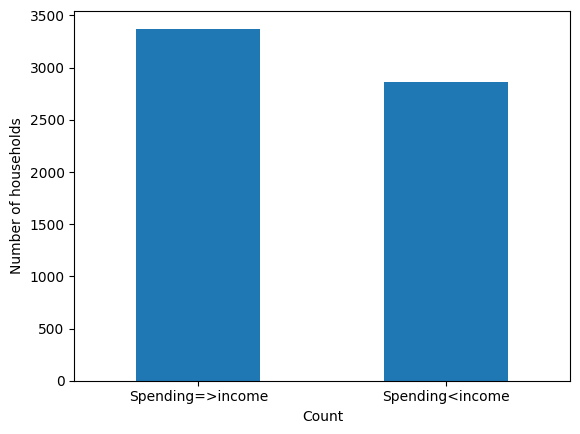

In [5]:
counts = dfs['q20c2']['RISPARFINE'].value_counts()
print(counts)

ax = counts.plot(kind='bar')
ax.set_xlabel('Count')
ax.set_ylabel('Number of households')
# 0 se spenderà meno del reddito annuo, riuscendo a mettere da parte qualche risparmio
# 1 se spenderà tutto il reddito annuo, senza riuscire a risparmiare nulla o spenderà più del reddito annuo, dovendo liquidare risparmi pregressi o indebitandosi
ax.set_xticklabels(['Spending=>income', 'Spending<income'])
plt.xticks(rotation=0)
plt.show()


We don't have an imbalanced dataset so we don't have to use techniques like SMOTE to under-sampling observations from the biggest class and to over-sampling observations from the smallest class.

In [6]:
#null_counts = {}
#for key, df in dfs.items():
#    null_counts[key + '_null'] = pd.DataFrame(df.isnull().sum())

for key, df in dfs.items():
    dfs[key] = df.dropna(axis=1)

#for key, null_df in null_counts.items():
#    print(f"Null value counts for {key}:\n{null_df}\n")

In [7]:
a1= dfs['q20c2'][ 'NQUEST'].value_counts()
a1

dfs['q20c2']= dfs['q20c2'][['NQUEST','RISPARFINE']]
dfs['q20c2']


,NQUEST,RISPARFINE
0,173,0
1,633,0
2,923,1
3,2886,1
4,3717,1
...,...,...
6234,975476,1
6235,975477,0
6236,975480,1
6237,975481,1


6239 rows × 45 columns

In [8]:
dfs['carcom20'][["nord"]].value_counts()

nord
1       6239
2       4722
3       2484
4       1334
5        333
6         72
7         10
8          3
9          1
dtype: int64

In [9]:
# rimuoviamo le righe riferite allo stesso nucleo famigliare (altri componenti della famiglia che hanno fatto il questionario)
dfs['carcom20']=dfs['carcom20'][dfs['carcom20']["nord"]==1]
dfs['carcom20'][["nord"]].value_counts()

nord
1       6239
dtype: int64

In [10]:
data_frames=[dfs['q20c2'],dfs['rfam20'],dfs['risfam20'],dfs['ricfam20'],dfs['carcom20'], dfs['debiti20']]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on='NQUEST', how='left'), data_frames)
print(df_merged.shape)


(6239, 95)


**The final dataset**

In [11]:
df_merged

,NQUEST,RISPARFINE,Y_x,YL,YL1,YL2,YT,YTP,YTP1,YTP2,...,ACOM4C,ACOM5,PESOFIT2,PESOFIT,PFIMM,PFAZ,PFCARTE,PFCC,PFCOLL,PFNOCOLL
0,173,0,33061.977405,0.0,0.0,0,23400.0,23400,23400,0,...,2,4,1604.870818,0.395431,0,0,0.0,0.0,0,0.0
1,633,0,15607.747176,0.0,0.0,0,10800.0,10800,10800,0,...,1,3,4162.874990,1.025708,0,0,0.0,0.0,0,0.0
2,923,1,10104.648305,0.0,0.0,0,6500.0,6500,6500,0,...,2,4,3606.350523,0.888584,0,0,0.0,0.0,0,0.0
3,2886,1,39295.685043,0.0,0.0,0,31043.0,43043,43043,0,...,2,3,1014.455405,0.249956,0,0,0.0,0.0,0,0.0
4,3717,1,6240.000000,0.0,0.0,0,6240.0,0,0,0,...,2,4,521.844832,0.128580,0,0,0.0,0.0,0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6234,975476,1,11415.666868,0.0,0.0,0,4000.0,0,0,0,...,2,3,2970.343173,0.731875,0,0,0.0,0.0,0,0.0
6235,975477,0,18833.274016,18762.0,18000.0,762,0.0,0,0,0,...,2,4,4043.561863,0.996310,0,0,0.0,0.0,0,0.0
6236,975480,1,12014.665714,0.0,0.0,0,11400.0,11400,11400,0,...,2,4,4740.128627,1.167940,0,0,0.0,0.0,0,0.0
6237,975481,1,24005.154029,0.0,0.0,0,18000.0,13000,13000,0,...,1,3,1637.380425,0.403441,0,0,0.0,0.0,0,0.0


(15198, 89) merge definitivo


In [12]:
df_merged.columns

Index(['NQUEST', 'RISPARFINE', 'Y_x', 'YL', 'YL1', 'YL2', 'YT', 'YTP', 'YTP1',
       'YTP2', 'YTA', 'YTA1', 'YTA11', 'YTA12', 'YTA2', 'YTA3', 'YTA31',
       'YTA32', 'YTA4', 'YTA5', 'YM', 'YC', 'YCA', 'YCA1', 'YCA2', 'YCF',
       'YCF1', 'YCF2', 'YCF3', 'YCF4', 'CLY', 'CLY2', 'Y_y', 'CN', 'CD1',
       'CD2', 'CD', 'C', 'S', 'AR1', 'AR2', 'AR3', 'BD1', 'BD2', 'BD', 'AF1',
       'AF2', 'AF3', 'AF4', 'PF1', 'PF2', 'PF3', 'PF', 'AR', 'AF', 'W', 'CLW',
       'CLW2', 'NCOMP', 'nord', 'SEX', 'PARENT', 'NASC', 'ANASC', 'CIT',
       'STACIV', 'STUDIO', 'B01', 'APQUAL2', 'b24', 'b25b', 'b25c', 'ETA',
       'IREG', 'CLETA5', 'QUAL', 'Q', 'SETT', 'CFRED', 'PERC', 'PERL', 'NPERL',
       'NPERC', 'AREA3', 'AREA5', 'ACOM4C', 'ACOM5', 'PESOFIT2', 'PESOFIT',
       'PFIMM', 'PFAZ', 'PFCARTE', 'PFCC', 'PFCOLL', 'PFNOCOLL'],
      dtype='object')

**rfam20, ovvero Aggregation of variables income account**: 'Y_x', 'YL', 'YL1', 'YL2', 'YT', 'YTP', 'YTP1',
       'YTP2', 'YTA', 'YTA1', 'YTA11', 'YTA12', 'YTA2', 'YTA3', 'YTA31',
       'YTA32', 'YTA4', 'YTA5', 'YM', 'YC', 'YCA', 'YCA1', 'YCA2', 'YCF',
       'YCF1', 'YCF2', 'YCF3', 'YCF4', 'CLY', 'CLY2',



**risfam20 Aggregation of variables: use of income account**: 'Y_y', 'CN', 'CD1',
       'CD2', 'CD', 'C', 'S'

**ricfam20 Aggregation of variables: capital account:** 'AR1', 'AR2', 'AR3', 'BD1', 'BD2', 'BD', 'AF1',
       'AF2', 'AF3', 'AF4', 'PF1', 'PF2', 'PF3', 'PF', 'AR', 'AF', 'W', 'CLW',
       'CLW2',

**CARCOM20 social-demographic characteristics**'NCOMP', 'nord', 'SEX', 'PARENT', 'NASC', 'ANASC', 'CIT',
       'STACIV', 'STUDIO', 'B01', 'APQUAL2', 'b24', 'b25b', 'b25c', 'ETA',
       'IREG', 'CLETA5', 'QUAL', 'Q', 'SETT', 'CFRED', 'PERC', 'PERL', 'NPERL',
       'NPERC', 'AREA3', 'AREA5', 'ACOM4C', 'ACOM5', 'PESOFIT2', 'PESOFIT'





In [13]:
columns_to_keep = ['YL', 'YTP','YTA', 'YM', 'YCA', 'YCF', 'C', 'CD', 'CN', 'S', 'W', 'AR1', 'AR2', 'AR3', 'AF', 'PF','PFCOLL','PFNOCOLL', 'CLETA5', 'NCOMP', 'NPERC', 'PERC', 'NPERL', 'PERL', 'Q', 'AREA3', 'ACOM4C', 'RISPARFINE',   ]
df_merged = df_merged[columns_to_keep]  # select only the specified columns



In [14]:
#columns_to_remove=["NQUEST", "PESOFIT", "PESOFIT2", 'NCOMP',  'nord',"ETA",'PARENT', 'NASC', 'ANASC', 'CIT',"STACIV", "STUDIO",  'B01','APQUAL2', 'b24', 'b25b', 'b25c', 'IREG', 'SETT', 'AREA3', 'ACOM5']

#df_merged= df_merged.drop(columns=columns_to_remove)


In [15]:
print(df_merged.shape)
df_merged

(6239, 28)


,YL,YTP,YTA,YM,YCA,YCF,C,CD,CN,S,...,CLETA5,NCOMP,NPERC,PERC,NPERL,PERL,Q,AREA3,ACOM4C,RISPARFINE
0,0.0,23400,0.0,0.0,9600.0,61.977405,27700.0,0,27700.0,5361.977405,...,5,1,1,1,0,0,3,3,2,0
1,0.0,10800,0.0,0.0,4800.0,7.747176,13020.0,0,13020.0,2587.747176,...,5,1,1,1,0,0,3,1,1,0
2,0.0,6500,0.0,0.0,3600.0,4.648305,9500.0,200,9300.0,604.648305,...,5,1,1,1,0,0,3,3,2,1
3,0.0,43043,-12000.0,0.0,8000.0,252.685043,22000.0,0,22000.0,17295.685043,...,5,2,2,1,0,0,3,3,2,1
4,0.0,0,6240.0,0.0,0.0,0.000000,10500.0,0,10500.0,-4260.000000,...,5,1,1,1,0,0,3,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6234,0.0,0,4000.0,2600.0,4800.0,15.666868,12450.0,650,11800.0,-1034.333132,...,2,2,2,1,2,1,3,3,2,1
6235,18762.0,0,0.0,0.0,0.0,71.274016,11062.0,0,11062.0,7771.274016,...,1,1,1,1,1,1,1,1,2,0
6236,0.0,11400,0.0,0.0,600.0,14.665714,11500.0,0,11500.0,514.665714,...,5,1,1,1,0,0,3,3,2,1
6237,0.0,13000,5000.0,0.0,6000.0,5.154029,19700.0,1300,18400.0,4305.154029,...,5,2,2,1,0,0,3,3,1,1


In [16]:
print(df_merged.columns)

Index(['YL', 'YTP', 'YTA', 'YM', 'YCA', 'YCF', 'C', 'CD', 'CN', 'S', 'W',
       'AR1', 'AR2', 'AR3', 'AF', 'PF', 'PFCOLL', 'PFNOCOLL', 'CLETA5',
       'NCOMP', 'NPERC', 'PERC', 'NPERL', 'PERL', 'Q', 'AREA3', 'ACOM4C',
       'RISPARFINE'],
      dtype='object')


In [17]:
column_summaries = {
                    'CLETA5': df_merged['CLETA5'].unique(),
                    'NCOMP': df_merged['NCOMP'].unique(),
                    'NPERC': df_merged['NPERC'].unique(),
                    'PERC': df_merged['PERC'].unique(),
                    'NPERL': df_merged['NPERL'].unique(),
                    'PERL': df_merged['PERL'].unique(),
                    'Q': df_merged['Q'].unique(),
                    'AREA5': df_merged['AREA3'].unique(),
                    'ACOM4C': df_merged['ACOM4C'].unique(),
                    'RISPARFINE': df_merged['RISPARFINE'].unique(),
                    }

for column, unique_values in column_summaries.items():
    print(f"{column}:")
    for value in unique_values:
        print(f"  - {value}")
    print()

CLETA5:
  - 5
  - 4
  - 3
  - 2
  - 1

NCOMP:
  - 1
  - 2
  - 4
  - 3
  - 6
  - 5
  - 9
  - 7
  - 8

NPERC:
  - 1
  - 2
  - 4
  - 3
  - 5
  - 6

PERC:
  - 1
  - 0

NPERL:
  - 0
  - 3
  - 1
  - 2
  - 4
  - 5
  - 6

PERL:
  - 0
  - 1

Q:
  - 3
  - 2
  - 1

AREA5:
  - 3
  - 1
  - 2

ACOM4C:
  - 2
  - 1
  - 0
  - 3

RISPARFINE:
  - 0
  - 1



(0.0, 100000.0)

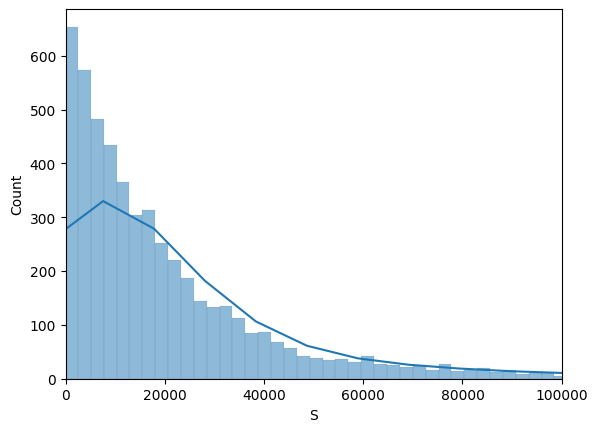

In [18]:
sns.histplot(df_merged['S'], kde=True)
#zooming in the plot
plt.xlim(0, 100000)


CLETA5 = classe di età (1=fino a 34 anni, 2=35-44, 3=45-54, 4=55-64, 5=oltre 64)

In [19]:
df_merged['Age'] = '<34'
df_merged.loc[df_merged['CLETA5'] == 2, 'Age'] = '[35,64]'
df_merged.loc[df_merged['CLETA5'] == 3, 'Age'] = '[35,64]'
df_merged.loc[df_merged['CLETA5'] == 4, 'Age'] = '[35,64]'
df_merged.loc[df_merged['CLETA5'] == 5, 'Age'] = '>64'

df_merged.drop(['CLETA5'], axis=1, inplace=True)

<ipython-input-19-970eb8b098d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Age'] = '<34'
<ipython-input-19-970eb8b098d4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.drop(['CLETA5'], axis=1, inplace=True)


In [20]:
age_counts = df_merged['Age'].value_counts()
print(age_counts)

[35,64]    3218
>64        2814
<34         207
Name: Age, dtype: int64


<Axes: >

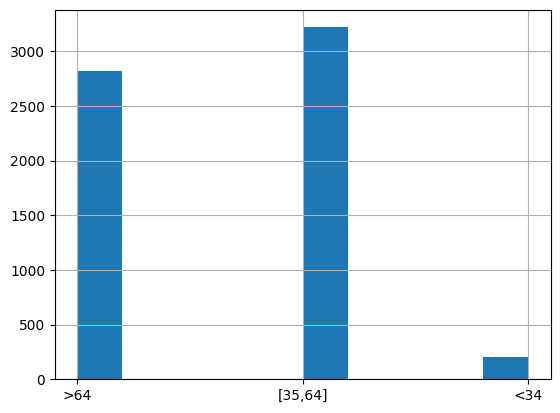

In [21]:
df_merged['Age'].hist()

In [22]:
#tabella_frequenza = df_merged['CLY'].value_counts().reset_index()
#tabella_frequenza.columns = ['CLY', 'Frequenza']

#print(tabella_frequenza)

NCOMP = numero di componenti della famiglia

In [23]:
tabella_frequenza = df_merged['NCOMP'].value_counts().reset_index()
tabella_frequenza.columns = ['NCOMP', 'Frequenza']
print(tabella_frequenza)

   NCOMP  Frequenza
0      2       2238
1      1       1517
2      3       1150
3      4       1001
4      5        261
5      6         62
6      7          7
7      8          2
8      9          1


In [24]:
df_merged['NCOMP_'] = '1'
df_merged.loc[df_merged['NCOMP'].isin([2, 3, 4]), 'NCOMP_'] = '[2,4]'
df_merged.loc[df_merged['NCOMP'].isin([5, 6, 7, 8]), 'NCOMP_'] = '>4'
print(df_merged['NCOMP_'])
df_merged.columns

0           1
1           1
2           1
3       [2,4]
4           1
        ...  
6234    [2,4]
6235        1
6236        1
6237    [2,4]
6238    [2,4]
Name: NCOMP_, Length: 6239, dtype: object


<ipython-input-24-89b6ed916c34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['NCOMP_'] = '1'


Index(['YL', 'YTP', 'YTA', 'YM', 'YCA', 'YCF', 'C', 'CD', 'CN', 'S', 'W',
       'AR1', 'AR2', 'AR3', 'AF', 'PF', 'PFCOLL', 'PFNOCOLL', 'NCOMP', 'NPERC',
       'PERC', 'NPERL', 'PERL', 'Q', 'AREA3', 'ACOM4C', 'RISPARFINE', 'Age',
       'NCOMP_'],
      dtype='object')

Calculate the ratio of NPERC to NCOMP.
Create a new variable that is equal to 1 if the ratio is greater than 0.5 and 0 otherwise.

In [25]:
# Calculate the ratio of NPERC to NCOMP
df_merged['Ratio'] = df_merged['NPERC'] / df_merged['NCOMP']
df_merged['INCOME_EARNER_PROP'] = 0
df_merged.loc[df_merged['Ratio'] > 0.5, 'INCOME_EARNER_PROP'] = 1
df_merged.drop(['Ratio'], axis=1, inplace=True)
df_merged.drop(['NPERC'], axis=1, inplace=True)

df_merged['INCOME_EARNER_PROP']


<ipython-input-25-88cd7db8b99e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Ratio'] = df_merged['NPERC'] / df_merged['NCOMP']
<ipython-input-25-88cd7db8b99e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['INCOME_EARNER_PROP'] = 0
<ipython-input-25-88cd7db8b99e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

0       1
1       1
2       1
3       1
4       1
       ..
6234    1
6235    1
6236    1
6237    1
6238    1
Name: INCOME_EARNER_PROP, Length: 6239, dtype: int64

Proporzione percettori di reddito DA LAVORO rispetto al numero di componenti
dfs['carcom20'][['NQUEST', 'PERC', 'PERL']]

In [26]:
# Calculate the ratio of NPERL to NCOMP
df_merged['Ratio'] = df_merged['NPERL'] / df_merged['NCOMP']
df_merged['INCOME_L_EARNER_PROP'] = 0
df_merged.loc[df_merged['Ratio'] > 0.5, 'INCOME_L_EARNER_PROP'] = 1
df_merged.drop(['Ratio'], axis=1, inplace=True)
df_merged.drop(['NPERL'], axis=1, inplace=True)

df_merged['INCOME_L_EARNER_PROP']

<ipython-input-26-76c7e8849f80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Ratio'] = df_merged['NPERL'] / df_merged['NCOMP']
<ipython-input-26-76c7e8849f80>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['INCOME_L_EARNER_PROP'] = 0
<ipython-input-26-76c7e8849f80>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

0       0
1       0
2       0
3       0
4       0
       ..
6234    1
6235    1
6236    0
6237    0
6238    0
Name: INCOME_L_EARNER_PROP, Length: 6239, dtype: int64

In [27]:
# ora non serve più
df_merged.drop(['NCOMP'], axis=1, inplace=True)

<ipython-input-27-d6a988b29809>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.drop(['NCOMP'], axis=1, inplace=True)


ACOM4C ampiezza demografica del comune (0=fino a 20.000 abitanti, 1=20.000-40.000, 2=40.000-500.000, 3=oltre 500.000)

In [28]:
tabella_frequenza = df_merged['ACOM4C'].value_counts().reset_index()
tabella_frequenza.columns = ['ACOM4C', 'Frequenza']
print(tabella_frequenza)

   ACOM4C  Frequenza
0       2       3139
1       1       1065
2       0       1043
3       3        992


In [29]:
df_merged["TOWN_SIZE"]= 0
df_merged.loc[df_merged["ACOM4C"].isin([1,2]),"TOWN_SIZE"]=1
df_merged.loc[df_merged["ACOM4C"]==2,"TOWN_SIZE"]=2
df_merged.drop(['ACOM4C'], axis=1, inplace=True)
tabella_frequenza = df_merged['TOWN_SIZE'].value_counts().reset_index()
tabella_frequenza.columns = ['TOWN_SIZE', 'Frequenza']
print(tabella_frequenza)

   TOWN_SIZE  Frequenza
0          2       3139
1          0       2035
2          1       1065


<ipython-input-29-e9210cad4598>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["TOWN_SIZE"]= 0
<ipython-input-29-e9210cad4598>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.drop(['ACOM4C'], axis=1, inplace=True)


COLONNE FINALI

In [30]:
df_merged.columns

Index(['YL', 'YTP', 'YTA', 'YM', 'YCA', 'YCF', 'C', 'CD', 'CN', 'S', 'W',
       'AR1', 'AR2', 'AR3', 'AF', 'PF', 'PFCOLL', 'PFNOCOLL', 'PERC', 'PERL',
       'Q', 'AREA3', 'RISPARFINE', 'Age', 'NCOMP_', 'INCOME_EARNER_PROP',
       'INCOME_L_EARNER_PROP', 'TOWN_SIZE'],
      dtype='object')

In [31]:
column_summaries = {
                    'Age': df_merged['Age'].unique(),
                    'NCOMP_': df_merged['NCOMP_'].unique(),
                    'INCOME_EARNER_PROP': df_merged['INCOME_EARNER_PROP'].unique(),
                    'PERC': df_merged['PERC'].unique(),
                    'INCOME_L_EARNER_PROP': df_merged['INCOME_L_EARNER_PROP'].unique(),
                    'PERL': df_merged['PERL'].unique(),
                    'Q': df_merged['Q'].unique(),
                    'AREA3': df_merged['AREA3'].unique(),
                    'TOWN_SIZE': df_merged['TOWN_SIZE'].unique(),
                    'RISPARFINE': df_merged['RISPARFINE'].unique(),
                    }

for column, unique_values in column_summaries.items():
    print(f"{column}:")
    for value in unique_values:
        print(f"  - {value}")
    print()

Age:
  - >64
  - [35,64]
  - <34

NCOMP_:
  - 1
  - [2,4]
  - >4

INCOME_EARNER_PROP:
  - 1
  - 0

PERC:
  - 1
  - 0

INCOME_L_EARNER_PROP:
  - 0
  - 1

PERL:
  - 0
  - 1

Q:
  - 3
  - 2
  - 1

AREA3:
  - 3
  - 1
  - 2

TOWN_SIZE:
  - 2
  - 1
  - 0

RISPARFINE:
  - 0
  - 1



#### Creations of DUMMY variables

In [32]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_merged['NCOMP_'] = label_encoder.fit_transform(df_merged['NCOMP_'])

<ipython-input-32-556121e10b83>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['NCOMP_'] = label_encoder.fit_transform(df_merged['NCOMP_'])


In [33]:
df_merged['NCOMP_']

0       0
1       0
2       0
3       2
4       0
       ..
6234    2
6235    0
6236    0
6237    2
6238    2
Name: NCOMP_, Length: 6239, dtype: int64

In [34]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['Q', 'AREA3', 'Age', 'NCOMP_', 'TOWN_SIZE']

# Assuming df_merged is your DataFrame
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
one_hot_encoded = one_hot_encoder.fit_transform(df_merged[categorical_cols])

# Get feature names from encoder's categories_
feature_names = one_hot_encoder.get_feature_names_out(categorical_cols)

one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=feature_names)
one_hot_encoded.index = df_merged.index
df_merged = df_merged.drop(columns=categorical_cols)
df_merged = pd.concat([df_merged, one_hot_encoded], axis=1)

df_merged


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,YL,YTP,YTA,YM,YCA,YCF,C,CD,CN,S,...,Q_2,Q_3,AREA3_2,AREA3_3,Age_>64,"Age_[35,64]",NCOMP__1,NCOMP__2,TOWN_SIZE_1,TOWN_SIZE_2
0,0.0,23400,0.0,0.0,9600.0,61.977405,27700.0,0,27700.0,5361.977405,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,10800,0.0,0.0,4800.0,7.747176,13020.0,0,13020.0,2587.747176,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,6500,0.0,0.0,3600.0,4.648305,9500.0,200,9300.0,604.648305,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,43043,-12000.0,0.0,8000.0,252.685043,22000.0,0,22000.0,17295.685043,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0,6240.0,0.0,0.0,0.000000,10500.0,0,10500.0,-4260.000000,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6234,0.0,0,4000.0,2600.0,4800.0,15.666868,12450.0,650,11800.0,-1034.333132,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6235,18762.0,0,0.0,0.0,0.0,71.274016,11062.0,0,11062.0,7771.274016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6236,0.0,11400,0.0,0.0,600.0,14.665714,11500.0,0,11500.0,514.665714,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6237,0.0,13000,5000.0,0.0,6000.0,5.154029,19700.0,1300,18400.0,4305.154029,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


In [35]:
print(df_merged.columns)
df_merged

Index(['YL', 'YTP', 'YTA', 'YM', 'YCA', 'YCF', 'C', 'CD', 'CN', 'S', 'W',
       'AR1', 'AR2', 'AR3', 'AF', 'PF', 'PFCOLL', 'PFNOCOLL', 'PERC', 'PERL',
       'RISPARFINE', 'INCOME_EARNER_PROP', 'INCOME_L_EARNER_PROP', 'Q_2',
       'Q_3', 'AREA3_2', 'AREA3_3', 'Age_>64', 'Age_[35,64]', 'NCOMP__1',
       'NCOMP__2', 'TOWN_SIZE_1', 'TOWN_SIZE_2'],
      dtype='object')


,YL,YTP,YTA,YM,YCA,YCF,C,CD,CN,S,...,Q_2,Q_3,AREA3_2,AREA3_3,Age_>64,"Age_[35,64]",NCOMP__1,NCOMP__2,TOWN_SIZE_1,TOWN_SIZE_2
0,0.0,23400,0.0,0.0,9600.0,61.977405,27700.0,0,27700.0,5361.977405,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,10800,0.0,0.0,4800.0,7.747176,13020.0,0,13020.0,2587.747176,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,6500,0.0,0.0,3600.0,4.648305,9500.0,200,9300.0,604.648305,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,43043,-12000.0,0.0,8000.0,252.685043,22000.0,0,22000.0,17295.685043,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0,6240.0,0.0,0.0,0.000000,10500.0,0,10500.0,-4260.000000,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6234,0.0,0,4000.0,2600.0,4800.0,15.666868,12450.0,650,11800.0,-1034.333132,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6235,18762.0,0,0.0,0.0,0.0,71.274016,11062.0,0,11062.0,7771.274016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6236,0.0,11400,0.0,0.0,600.0,14.665714,11500.0,0,11500.0,514.665714,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6237,0.0,13000,5000.0,0.0,6000.0,5.154029,19700.0,1300,18400.0,4305.154029,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


In [36]:
# Check if all columns are numeric
is_numeric = df_merged.apply(pd.to_numeric, errors='coerce').notnull().all()

# Count the rows that are non-numeric
non_numeric_rows = df_merged.apply(pd.to_numeric, errors='coerce').isnull().any(axis=1).sum()

print("Are all columns numeric?", is_numeric.all())
print("Number of non-numeric rows:", non_numeric_rows)

df_merged = df_merged.apply(pd.to_numeric, errors='coerce').dropna()

# Convert all columns to float
df_merged = df_merged.astype(float)



Are all columns numeric? True
Number of non-numeric rows: 0


In [37]:
'''
print(df_merged.shape)
# Calculate z-scores for each column in the dataframe
z_scores = np.abs(stats.zscore(df_merged))

# Set the threshold for identifying outliers
threshold = 5

# Find the indices of the outliers
outlier_indices = np.where(z_scores > threshold)

# print how many outliers were found in each column named with its name
for col, col_outliers in zip(df_merged.columns, np.sum(z_scores > threshold, axis=0)):
    print(f"{col}: {col_outliers}")

# Remove the outliers from the dataframe\
df_merged = df_merged[(z_scores < threshold).all(axis=1)]
df_merged.shape
print(df_merged.shape)
'''

'\nprint(df_merged.shape)\n# Calculate z-scores for each column in the dataframe\nz_scores = np.abs(stats.zscore(df_merged))\n\n# Set the threshold for identifying outliers\nthreshold = 5\n\n# Find the indices of the outliers\noutlier_indices = np.where(z_scores > threshold)\n\n# print how many outliers were found in each column named with its name\nfor col, col_outliers in zip(df_merged.columns, np.sum(z_scores > threshold, axis=0)):\n    print(f"{col}: {col_outliers}")\n\n# Remove the outliers from the dataframedf_merged = df_merged[(z_scores < threshold).all(axis=1)]\ndf_merged.shape\nprint(df_merged.shape)\n'

In [38]:
df_merged.columns

# rename  'Age_<34' to 'Age_lower34'
df_merged.rename(columns={'Age_<34': 'Age_lower34', 'Age_>64': 'Age_greater64', 'NCOMP__>4': 'NCOMP_greater4', 'Age_[35,64]': 'Age_35_54', 'NCOMP__[2,4]': 'NCOMP_2_4'}, inplace=True)

df_merged.columns

Index(['YL', 'YTP', 'YTA', 'YM', 'YCA', 'YCF', 'C', 'CD', 'CN', 'S', 'W',
       'AR1', 'AR2', 'AR3', 'AF', 'PF', 'PFCOLL', 'PFNOCOLL', 'PERC', 'PERL',
       'RISPARFINE', 'INCOME_EARNER_PROP', 'INCOME_L_EARNER_PROP', 'Q_2',
       'Q_3', 'AREA3_2', 'AREA3_3', 'Age_greater64', 'Age_35_54', 'NCOMP__1',
       'NCOMP__2', 'TOWN_SIZE_1', 'TOWN_SIZE_2'],
      dtype='object')

## **INIZIO ANALISI**

### Correlation analysis

C              CN               0.971432
CN             C                0.971432
AF             YCF              0.891108
YCF            AF               0.891108
W              AR2              0.890977
                                  ...   
PERL           Age_greater64   -0.630702
Age_greater64  Age_35_54       -0.935512
Age_35_54      Age_greater64   -0.935512
PERL           Q_3             -0.970272
Q_3            PERL            -0.970272
Length: 1056, dtype: float64


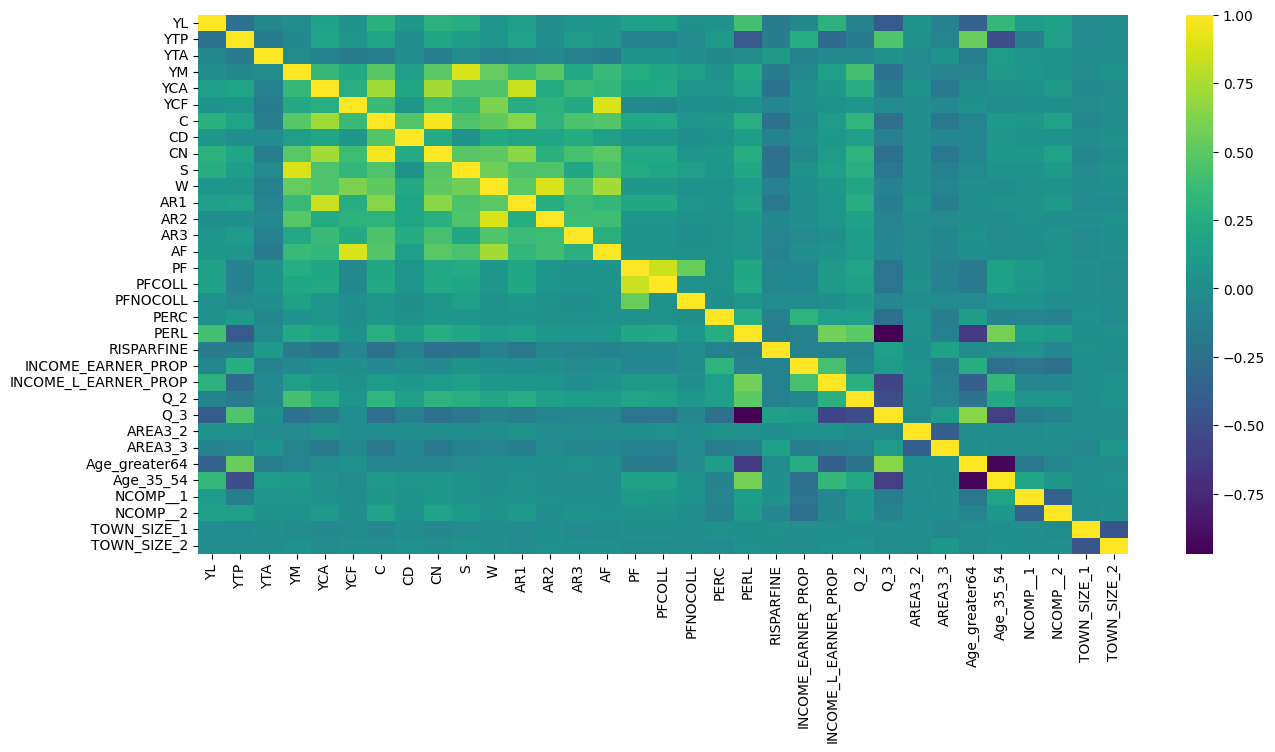

In [39]:
# Calcola la matrice di correlazione
corr_matrix = df_merged.corr()
sorted_corr = corr_matrix.unstack().sort_values(ascending=False)
sorted_corr = sorted_corr[sorted_corr != 1]
print(sorted_corr)

plt.figure(figsize=(15, 7))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.savefig('DataCorr.pdf', dpi='figure', format='pdf')
plt.show()


Looking at this correlation matrix we can notice some potential multicollinearity issues.

### Splitting the dataset in training, test and validation

In [40]:
from sklearn.model_selection import train_test_split

#training set (80%) e test set (20%)
train, test_data = train_test_split(df_merged, test_size=0.2, random_state=42)
#test set diviso in due
test, val = train_test_split(test_data, test_size=0.5, random_state=42)

# train 0,8, test 0.1, val 0.1
print("Size of train: ", len(train))
print("Size of train: ", len(test))
print("Size of train: ", len(val))

Size of train:  4991
Size of train:  624
Size of train:  624


In [41]:
#Define x
X_train = train.drop(columns=['RISPARFINE' ])
X_val= val.drop(columns=['RISPARFINE' ])
X_test= test.drop(columns=['RISPARFINE' ])
# Define y
y_train = train[['RISPARFINE']]
y_val = val[['RISPARFINE']]
y_test = test[['RISPARFINE']]

In [42]:
# Counting defaulted loans
freq = y_train.value_counts()

# Calculating the percentage of defaulted loans
pos_exp = freq / sum(freq) * 100

# Printing the results
print('Percentage of spending>=income:', pos_exp[1])
print('Percentage of spending<income is:', 100 - pos_exp[1])

Percentage of spending>=income: 54.498096573832896
Percentage of spending<income is: 45.501903426167104


### Logistic regression without standardization

In [43]:
# Call Logistic Regression
LogReg = LogisticRegression(penalty=None, solver="newton-cg")

# Fit training data on logistic regression
LogReg.fit(X_train, y_train)

# Get the coefficients of each feature
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(LogReg.intercept_) + list(LogReg.coef_[0])
    ],
).transpose().set_index(0)

coeffs.columns = ['weight']
coeffs.index.name = 'feature'
coeffs




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


,weight
feature,
intercept,0.233383
YL,-0.000003
YTP,-0.000012
YTA,0.000042
YM,0.000006
YCA,-0.000007
YCF,-0.000054
C,-0.00001
CD,-0.000013


In [44]:
# Obtain predicted probabilities for training, validation, and test sets
y_train_pred = LogReg.predict_proba(X_train)
y_val_pred = LogReg.predict_proba(X_val)
y_test_pred = LogReg.predict_proba(X_test)

# Calculate maximum likelihood for training, validation, and test sets
mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:, 1], y_train_pred[:, 0]))
mle_vector_val = np.log(np.where(y_val == 1, y_val_pred[:, 1], y_val_pred[:, 0]))
mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:, 1], y_test_pred[:, 0]))

# Calculate cost functions from maximum likelihoods
cost_function_training = np.negative(np.sum(mle_vector_train) / len(y_train))
cost_function_val = np.negative(np.sum(mle_vector_val) / len(y_val))
cost_function_test = np.negative(np.sum(mle_vector_test) / len(y_test))

# Printing the results
print('Cost function training set =', cost_function_training)
print('Cost function validation set =', cost_function_val)
print('Cost function test set =', cost_function_test)

Cost function training set = 4021.4945666110575
Cost function validation set = 488.39305135365987
Cost function test set = 517.7302654526284


In [45]:
variable_names= X_train.columns

###Standardization

In [46]:
df_merged.columns

Index(['YL', 'YTP', 'YTA', 'YM', 'YCA', 'YCF', 'C', 'CD', 'CN', 'S', 'W',
       'AR1', 'AR2', 'AR3', 'AF', 'PF', 'PFCOLL', 'PFNOCOLL', 'PERC', 'PERL',
       'RISPARFINE', 'INCOME_EARNER_PROP', 'INCOME_L_EARNER_PROP', 'Q_2',
       'Q_3', 'AREA3_2', 'AREA3_3', 'Age_greater64', 'Age_35_54', 'NCOMP__1',
       'NCOMP__2', 'TOWN_SIZE_1', 'TOWN_SIZE_2'],
      dtype='object')

Categorical variable: 'CLW', 'CLW2', 'SEX',
       'CLETA5', 'QUAL', 'Q', 'CFRED', 'PERC', 'PERL', 'NPERL', 'NPERC',
       'AREA5', 'ACOM4C'



In [47]:
continuous_var= ['YL', 'YTP', 'YTA', 'YM', 'YCA', 'YCF', 'C', 'CD', 'CN', 'S', 'W', 'AR1', 'AR2', 'AR3', 'AF', 'PF','PFNOCOLL', 'PFCOLL' ]

In [48]:
scaler = StandardScaler()

df_merged[continuous_var] = scaler.fit_transform(df_merged[continuous_var])


In [49]:
np.random.seed(42)
train, test_data = train_test_split(df_merged, test_size=0.2, random_state=42)
test, val = train_test_split(test_data, test_size=0.5, random_state=42)

X_train_sdz = train.drop(columns=['RISPARFINE' ])
X_val_sdz = val.drop(columns=['RISPARFINE' ])
X_test_sdz = test.drop(columns=['RISPARFINE' ])

y_train_sdz = train['RISPARFINE']
y_val_sdz = val['RISPARFINE']
y_test_sdz = test['RISPARFINE']
#y_train_sdz = train[['RISPARFINE']].values




In [50]:
# Call Logistic Regression
LogReg_sdz1 = LogisticRegression(penalty=None, solver="newton-cg")

# Fit training data on logistic regression
LogReg_sdz1.fit(X_train_sdz, y_train_sdz)

# Get the coefficients of each feature
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train_sdz.columns),
        list(LogReg_sdz1.intercept_) + list(LogReg_sdz1.coef_[0])
    ],
).transpose().set_index(0)

coeffs.columns = ['weight']
coeffs.index.name = 'feature'
coeffs


,weight
feature,
intercept,-0.232528
YL,-0.385809
YTP,-0.490577
YTA,0.064296
YM,-0.069111
YCA,-0.251798
YCF,-0.679973
C,-0.069142
CD,-0.080323


#### Pacchetto alternativo per fare logistic

In [51]:
import statsmodels.api as sm
smlog = sm.Logit(y_train_sdz,sm.add_constant(X_train_sdz)).fit()
smlog.summary()

         Current function value: 0.604483
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             RISPARFINE   No. Observations:                 4991
Model:                          Logit   Df Residuals:                     4958
Method:                           MLE   Df Model:                           32
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.1228
Time:                        10:44:08   Log-Likelihood:                -3017.0
converged:                      False   LL-Null:                       -3439.3
Covariance Type:            nonrobust   LLR p-value:                7.602e-157
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2325      0.384     -0.605      0.545      -0.986       0.521
YL                      -0.3901   1.13e+06  -3.45e-07      1.000   -2.22e+06    2.22e+06
YTP                     -0.4936   8.08e+05  -6.11e-07      1.000   -1.58e+06    1.58e+06
YTA                      0.0637    1.5e+05   4.25e-07      1.000   -2.94e+05    2.94e+05
YM                      -0.0793   2.68e+06  -2.96e-08      1.000   -5.25e+06    5.25e+06
YCA                     -0.2547   7.72e+05   -3.3e-07      1.000   -1.51e+06    1.51e+06
YCF                     -0.6818   4.93e+05  -1.38e-06      1.000   -9.67e+05    9.67e+05
C                       -0.0679        nan        nan        nan         nan         nan
CD                      -0.0795        nan        nan        nan         nan         nan
CN                      -0.0511        nan        nan        nan         nan         nan
S                       -0.5248   2.71e+06  -1.93e-07      1.000   -5.32e+06    5.32e+06
W                        0.0696        nan        nan        nan         nan         nan
AR1                      0.1425        nan        nan        nan         nan         nan
AR2                      0.0610        nan        nan        nan         nan         nan
AR3                      0.0528        nan        nan        nan         nan         nan
AF                       0.0189        nan        nan        nan         nan         nan
PF                       0.1630        nan        nan        nan         nan         nan
PFCOLL                  -0.1611      0.224     -0.718      0.473      -0.601       0.279
PFNOCOLL                 0.0016      0.138      0.012      0.991      -0.270       0.273
PERC                     0.0063      0.165      0.038      0.969      -0.317       0.330
PERL                    -0.3217      0.299     -1.077      0.281      -0.907       0.264
INCOME_EARNER_PROP      -0.1293      0.106     -1.223      0.221      -0.337       0.078
INCOME_L_EARNER_PROP    -0.0684      0.119     -0.575      0.565      -0.302       0.165
Q_2                     -0.2628      0.123     -2.139      0.032      -0.504      -0.022
Q_3                      0.1516      0.298      0.508      0.611      -0.433       0.736
AREA3_2                  0.2637      0.081      3.255      0.001       0.105       0.422
AREA3_3                  0.3988      0.073      5.456      0.000       0.256       0.542
Age_greater64           -0.0287      0.191     -0.150      0.880      -0.403       0.346
Age_35_54                0.1593      0.170      0.938      0.348      -0.174       0.492
NCOMP__1                 0.6667      0.176      3.782      0.000       0.321       1.012
NCOMP__2                 0.2308      0.087      2.653      0.008       0.060       0.401
TOWN_SIZE_1              0.1182      0.092      1.287      0.198      -0.062       0.298
TOWN_SIZE_2              0.1350      0.070      1.930      0.054      -0.002       0.272
=====================================

In [52]:
test.drop(columns=['RISPARFINE' ])

,YL,YTP,YTA,YM,YCA,YCF,C,CD,CN,S,...,Q_2,Q_3,AREA3_2,AREA3_3,Age_greater64,Age_35_54,NCOMP__1,NCOMP__2,TOWN_SIZE_1,TOWN_SIZE_2
5412,-0.539757,-0.686929,-0.083547,0.135822,-0.357364,-0.190270,-0.403480,0.053930,-0.456723,-0.251383,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426,-0.539757,-0.078126,-0.083547,-0.244648,-0.373191,-0.059807,-0.567117,-0.227079,-0.560756,-0.351252,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1477,1.188515,-0.686929,-0.083547,-0.244648,-0.098861,-0.049347,-0.103696,-0.160172,-0.070725,0.055630,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3664,-0.539757,1.280206,-0.083547,-0.244648,-0.578938,-0.060191,-0.249661,-0.227079,-0.212783,-0.151159,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4439,0.162353,-0.686929,0.623281,0.029290,-0.357364,-0.050184,-0.267988,-0.227079,-0.232873,-0.061346,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,-0.539757,0.198282,-0.083547,-0.244648,-0.325711,-0.053406,-0.581844,-0.227079,-0.576899,-0.247530,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2885,0.121679,0.231067,0.223559,-0.168554,0.043580,-0.120465,-0.288934,-0.227079,-0.255832,0.088653,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4421,0.583620,-0.686929,-0.137918,-0.244648,-0.372120,-0.057887,-0.478088,-0.227079,-0.463169,-0.107194,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1919,0.134160,0.296638,0.047765,-0.244648,-0.135790,-0.039361,-0.093878,-0.160172,-0.059963,-0.097219,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## regulatization: RIDGE, LASSO, ELASTIC NET

#### **Ridge**

In [53]:
# The alpha used by Python's ridge should be the lambda in Hull's book times the number of observations
n_alphas = 50
alphas = np.logspace(-7, -1, n_alphas)

mses=[]
mean_abs_weights=[]
coefs = []
for alpha in alphas:
    ridge = LogisticRegression(C=alpha, solver='lbfgs', penalty="l2", fit_intercept=False)
    ridge.fit(X_train_sdz,y_train_sdz)
    coefs.append(ridge.coef_)
    pred=ridge.predict(X_val_sdz)
    mses.append(mse(y_val_sdz,pred))
    mean_abs_weights.append(np.abs(ridge.coef_[0]).mean())

print(mses)
print(mean_abs_weights)

[0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34615384615384615, 0.34935897435897434, 0.34935897435897434, 0.34775641025641024, 0.34615384615384615, 0.34615384615384615, 0.34294871794871795, 0.34455128205128205, 0.34294871794871795, 0.34294871794871795, 0.33814102564102566, 0.33814102564102566, 0.3301282051282051, 0.32371794871794873, 0.32371794871794873, 0.32051282051282054, 0.328525641025641, 0.32211538461538464, 0.3157051282051282, 0.3108974358974359, 0.3076923076923077, 0.3108974358974359, 0.30448717948717946, 0.30288461538461536, 0.30288461538461536, 0.30288461538461536, 0.30288461538461536, 0.30288461538461536, 0.3125, 0.3141025641025641, 0.3157051282

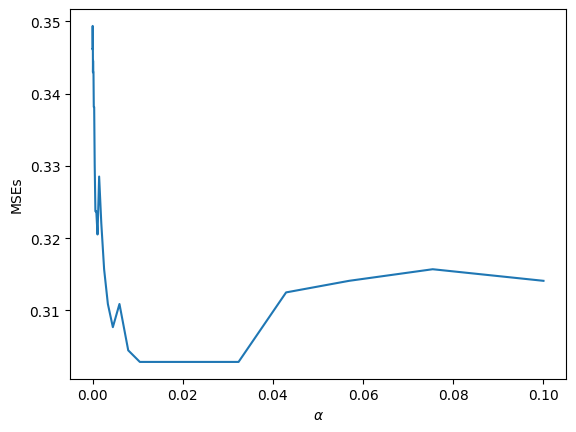

In [54]:
mses_ridge = pd.DataFrame.transpose(pd.DataFrame([alphas,mses]))
plt.plot(alphas, mses)
plt.xlabel(r'$\alpha$')
plt.ylabel('MSEs')
plt.show()

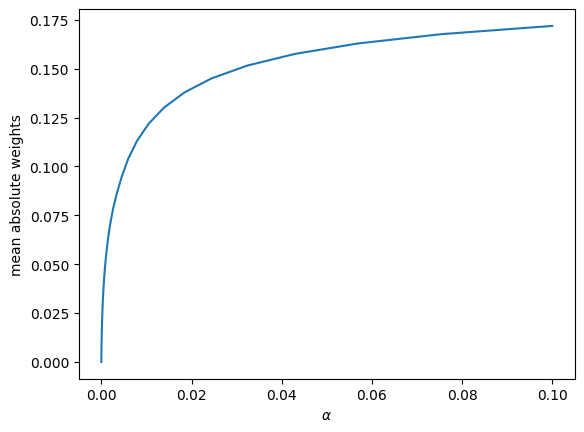

In [55]:
maw_ridge = pd.DataFrame.transpose(pd.DataFrame([alphas,mean_abs_weights]))
plt.plot(alphas, mean_abs_weights)
plt.xlabel(r'$\alpha$')
plt.ylabel('mean absolute weights')
plt.show()

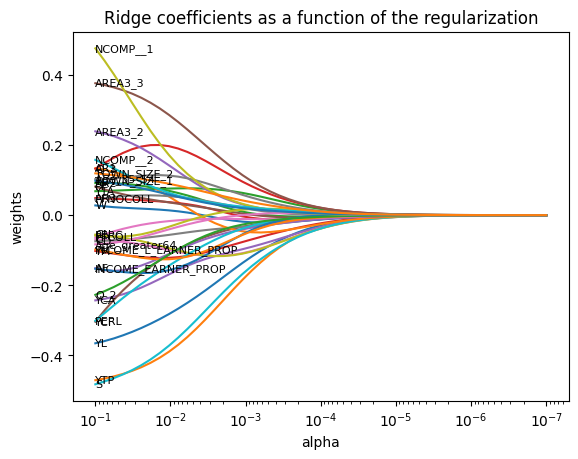

In [56]:
ax = plt.gca()
coefs_flat = np.squeeze(coefs)

ax.plot(alphas, coefs_flat)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")

for i, var_name in enumerate(variable_names):
    ax.text(alphas[-1], coefs_flat[-1, i], var_name, fontsize=8, ha='left', va='center')

plt.show()

In [57]:
# LogisticRegressionCV for Automatic Alpha Selection
n_alphas = 75
alphas = np.logspace(-7, -1, n_alphas)

ridge_cv= LogisticRegressionCV(penalty='l2', solver='lbfgs', Cs= alphas)
ridge_cv.fit(X_train_sdz,y_train_sdz)
print("Best paramether C:", ridge_cv.C_)

Best paramether C: [0.0473888]


In [58]:
LogReg_l2 = LogisticRegression(penalty="l2", solver="lbfgs", C=ridge_cv.C_[0])
LogReg_l2.fit(X_train_sdz,y_train_sdz)
LogReg_l2.predict_proba(X_train_sdz)

coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train_sdz.columns),
        list(LogReg_l2.intercept_) + list(LogReg_l2.coef_[0])
    ]
).transpose().set_index(0)
coeffs


,1
0,
intercept,-0.062053
YL,-0.346297
YTP,-0.458257
YTA,0.070123
YM,-0.112648
YCA,-0.228216
YCF,-0.225602
C,-0.074938
CD,-0.070696


#### **Lasso**

[0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.3541666666666667, 0.3317307692307692, 0.3269230769230769, 0.32371794871794873, 0.32371794871794873, 0.32371794871794873, 0.3173076923076923, 0.3189102564102564, 0.3189102564102564, 0.3173076923076923, 0.3173076923076923, 0.3189102564102564, 0.32371794871794873, 0.32532051282051283, 0.32532051282051283, 0.32211538461538464, 0.32371794871794873, 0.3269230769230769, 0.328525641025641, 0.32532051282051283, 0.3173076923076923, 0.3108974358974359, 0.3092948717948718, 0.3108974358974359, 0.3108974358974359, 0.3141025641025641, 0.3141025641025641, 0.3092948717948718, 0.3125]
[2.

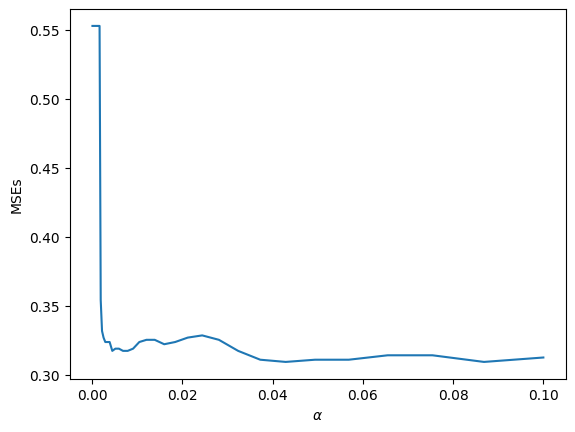

In [59]:
n_alphas = 50
alphas = np.logspace(-4, -1, n_alphas)

mses_lasso=[]
mean_abs_weights_lasso=[]
coefs=[]
for alpha in alphas:
    lasso = LogisticRegression(C=alpha, solver='saga', penalty='l1', fit_intercept=False, max_iter=1000)
    lasso.fit(X_train_sdz,y_train_sdz)
    pred=lasso.predict(X_val_sdz)
    coefs.append(lasso.coef_)
    mses_lasso.append(mse(y_val_sdz,pred))
    mean_abs_weights_lasso.append(np.abs(lasso.coef_[0]).mean())

print(mses_lasso)
print(mean_abs_weights)

plt.plot(alphas, mses_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('MSEs')
plt.show()

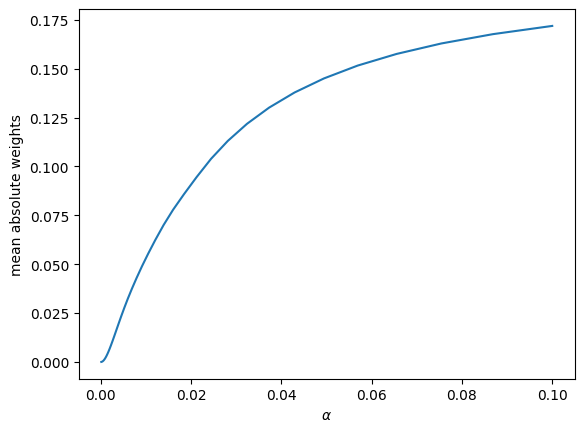

In [60]:
maw_lasso = pd.DataFrame.transpose(pd.DataFrame([alphas,mean_abs_weights]))
plt.plot(alphas, mean_abs_weights)
plt.xlabel(r'$\alpha$')
plt.ylabel('mean absolute weights')
plt.show()

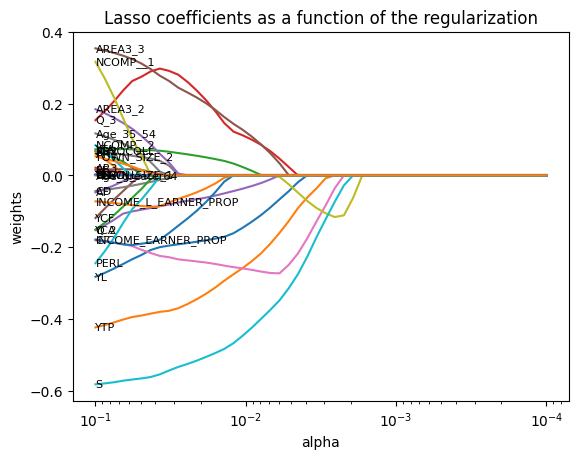

In [61]:
ax = plt.gca()
coefs_flat = np.squeeze(coefs)

ax.plot(alphas, coefs_flat)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")

for i, var_name in enumerate(variable_names):
    ax.text(alphas[-1], coefs_flat[-1, i], var_name, fontsize=8, ha='left', va='center')

plt.axis("tight")
plt.show()

In [62]:
# LogisticRegressionCV for Automatic Alpha Selection for LASSO
n_alphas = 50
alphas = np.logspace(-7, -1, n_alphas)

lasso_cv= LogisticRegressionCV(penalty='l1', solver='saga', Cs= alphas,max_iter=1000, cv=5)
lasso_cv.fit(X_train_sdz,y_train_sdz)
print("Best paramether C:", lasso_cv.C_)

Best paramether C: [0.05689866]


In [63]:
LogReg_l1 = LogisticRegression(penalty="l1", solver="saga", C=lasso_cv.C_[0])
LogReg_l1.fit(X_train_sdz,y_train_sdz)
LogReg_l1.predict_proba(X_train_sdz)

coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train_sdz.columns),
        list(LogReg_l1.intercept_) + list(LogReg_l1.coef_[0])
    ]
).transpose().set_index(0)
coeffs

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,1
0,
intercept,0.081778
YL,-0.253222
YTP,-0.412165
YTA,0.070882
YM,-0.000314
YCA,-0.122108
YCF,-0.02502
C,-0.124607
CD,-0.042189


### **ELASTIC NET**

[0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.5528846153846154, 0.34455128205128205, 0.33814102564102566, 0.3301282051282051, 0.328525641025641, 0.3301282051282051, 0.328525641025641, 0.3301282051282051, 0.3173076923076923, 0.3157051282051282, 0.3173076923076923, 0.3189102564102564, 0.32051282051282054, 0.32371794871794873, 0.3269230769230769, 0.328525641025641, 0.328525641025641, 0.3317307692307692, 0.3301282051282051, 0.3301282051282051, 0.3301282051282051, 0.32532051282051283, 0.3173076923076923, 0.3125, 0.3108974358974359, 0.3108974358974359, 0.3125, 0.3141025641025641, 0.3108974358974359, 0.3076923076923077, 0.3125, 0.3125, 0.3108974358974359, 0.3076923076923077, 0.3092948717948718]
[2.1819895156887453e-05, 2.8921004037503564e-0

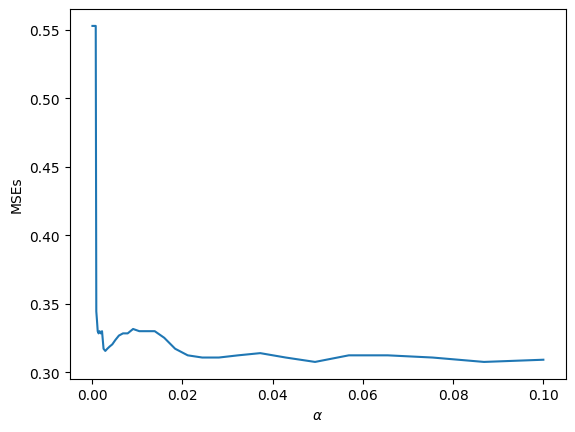

In [64]:
n_alphas = 50
alphas = np.logspace(-4, -1, n_alphas)

mses_el_net=[]
mean_abs_weights_el_net=[]
coefs=[]
for alpha in alphas:
    el_net = LogisticRegression(C=alpha, solver='saga', penalty='elasticnet', fit_intercept=False, l1_ratio=0.5, max_iter=1000)
    el_net.fit(X_train_sdz,y_train_sdz)
    pred=el_net.predict(X_val_sdz)
    coefs.append(el_net.coef_)
    mses_el_net.append(mse(y_val_sdz,pred))
    mean_abs_weights_el_net.append(np.abs(el_net.coef_[0]).mean())

print(mses_el_net)
print(mean_abs_weights)

plt.plot(alphas, mses_el_net)
plt.xlabel(r'$\alpha$')
plt.ylabel('MSEs')
plt.show()

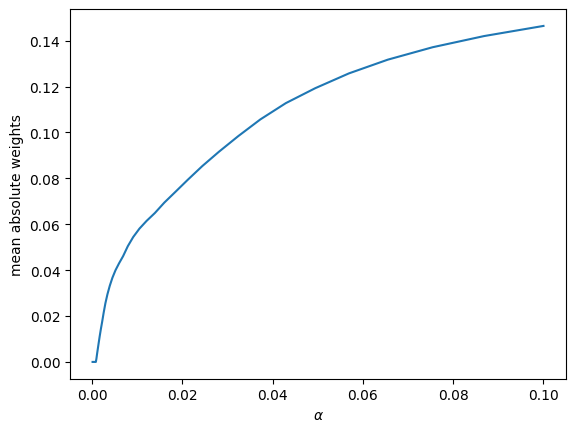

In [65]:
maw_lasso = pd.DataFrame.transpose(pd.DataFrame([alphas,mean_abs_weights_el_net]))
plt.plot(alphas, mean_abs_weights_el_net)
plt.xlabel(r'$\alpha$')
plt.ylabel('mean absolute weights')
plt.show()

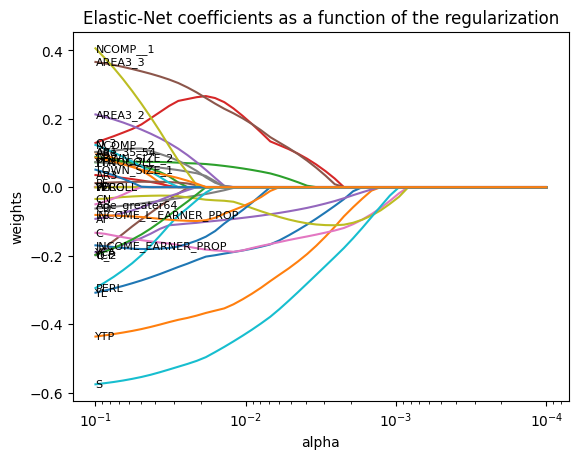

In [66]:
ax = plt.gca()
coefs_flat = np.squeeze(coefs)

ax.plot(alphas, coefs_flat)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Elastic-Net coefficients as a function of the regularization")

for i, var_name in enumerate(variable_names):
    ax.text(alphas[-1], coefs_flat[-1, i], var_name, fontsize=8, ha='left', va='center')

plt.axis("tight")
plt.show()

In [67]:
# LogisticRegressionCV for Automatic Alpha Selection for Elastic-Net (0.5)
n_alphas = 50
alphas = np.logspace(-7, -1, n_alphas)

el_net_cv= LogisticRegressionCV(penalty='elasticnet', solver='saga', Cs= alphas,fit_intercept=False, l1_ratios=[0.5], max_iter=1000)
el_net_cv.fit(X_train_sdz,y_train_sdz)
print("Best paramether C:", el_net_cv.C_)

Best paramether C: [0.1]


In [68]:
el_net = LogisticRegression(C=el_net_cv.C_[0], solver='saga', penalty='elasticnet', fit_intercept=False, l1_ratio=0.5, max_iter=1000)
el_net.fit(X_train_sdz,y_train_sdz)
el_net.predict_proba(X_train_sdz)

coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train_sdz.columns),
        list(el_net.intercept_) + list(el_net.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,0.0
YL,-0.308304
YTP,-0.436512
YTA,0.072502
YM,0.0
YCA,-0.189874
YCF,-0.198943
C,-0.133279
CD,-0.062486


# Performance evaluation

We have this models:


*   LogReg
*   LogReg_sdz1
*   LogReg_l2 (RIDGE)
*   LogReg_l1 (LASSO)
*   el_net (ELASTIC NET 0.5)



### Training set

#### LogReg Logistic Regression

Logistic regression
AUC  0.751310157484394
Gini index 0.502620314968788
J statistic=0.379960


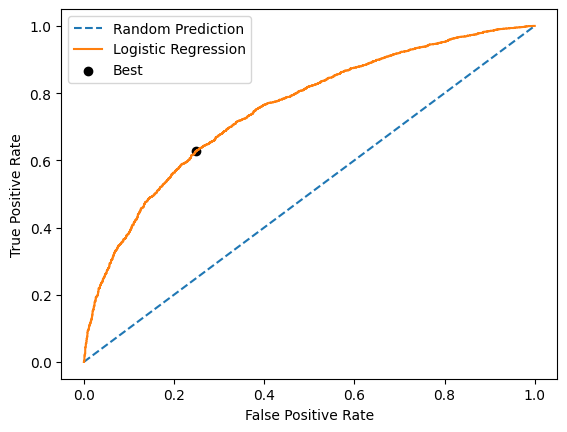

In [69]:
lr_prob=LogReg.predict_proba(X_train)
lr_prob=lr_prob[:,1]
ns_prob=[0 for _ in range(len(y_train))]
ns_auc=roc_auc_score(y_train, ns_prob)
lr_auc=roc_auc_score(y_train,lr_prob)
print('Logistic regression')
print("AUC ", lr_auc)

#calculate the gini index
gini_index=2*lr_auc-1
print("Gini index", gini_index)


ns_fpr,ns_tpr,_=roc_curve(y_train,ns_prob)
lr_fpr,lr_tpr,threshold_train=roc_curve(y_train,lr_prob)

# calculate the YOUDEN statistics
fpr, tpr, thresholds = roc_curve(y_train, lr_prob)
j_stat1 = tpr - fpr
ix = np.argmax(j_stat1)
best_thresh = thresholds[ix]
print('J statistic=%.6f' % ( j_stat1[ix]))



plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [70]:
# Threshold values
threshold = [.1, .2, .5, .8, .9]

# Create a dataframe to store results
results = pd.DataFrame(columns=["Threshold", "Accuracy", "TP rate", "TN rate", "FP rate", "Precision", "f-score"])

# Fill in the Threshold column
results['Threshold'] = threshold

# Initialize index variable
j = 0

# Iterate over the thresholds
for i in threshold:

    # If probability for the train set > threshold, predict 1
    preds = np.where(LogReg_sdz1.predict_proba(X_train_sdz)[:, 1] > i, 1, 0)

    # Create confusion matrix in percentage
    cm = (confusion_matrix(y_train_sdz, preds, labels=[1, 0], sample_weight=None) / len(y_train_sdz)) * 100

    # Display the confusion matrix for the current threshold
    print('Confusion matrix for threshold =', i)
    print(' ')

    TP = cm[0][0]  # True Positives
    FN = cm[0][1]  # False Positives
    FP = cm[1][0]  # True Negatives
    TN = cm[1][1]  # False Negatives

    ConMat = pd.DataFrame(
        [
            [cm[0][0], cm[0][1]],
            [cm[1][0], cm[1][1]]
        ], columns=['y_hat_1', 'y_hat_0']
    )
    ConMat.rename(index={0: 'y_1'}, inplace=True)
    ConMat.rename(index={1: 'y_0'}, inplace=True)

    print(ConMat)

    # Fill in the results dataframe
    results.iloc[j, 1] = accuracy_score(y_train_sdz, preds)
    results.iloc[j, 2] = recall_score(y_train_sdz, preds)
    results.iloc[j, 3] = TN / (FP + TN)  # True negative rate
    results.iloc[j, 4] = FP / (FP + TN)  # False positive rate
    results.iloc[j, 5] = precision_score(y_train_sdz, preds)
    results.iloc[j, 6] = f1_score(y_train_sdz, preds)

    j += 1

# Display all evaluation metrics
print('ALL METRICS')
print(results.T)

Confusion matrix for threshold = 0.1
 
       y_hat_1   y_hat_0
y_1  53.816870  0.681226
y_0  41.695051  3.806852
Confusion matrix for threshold = 0.2
 
       y_hat_1   y_hat_0
y_1  53.115608  1.382488
y_0  39.170507  6.331397
Confusion matrix for threshold = 0.5
 
       y_hat_1    y_hat_0
y_1  44.700461   9.797636
y_0  22.640753  22.861150
Confusion matrix for threshold = 0.8
 
      y_hat_1    y_hat_0
y_1  4.968944  49.529152
y_0  0.440793  45.061110
Confusion matrix for threshold = 0.9
 
      y_hat_1    y_hat_0
y_1  0.240433  54.257664
y_0  0.000000  45.501903
ALL METRICS
                  0         1         2         3         4
Threshold       0.1       0.2       0.5       0.8       0.9
Accuracy   0.576237   0.59447  0.675616  0.500301  0.457423
TP rate      0.9875  0.974632  0.820221  0.091176  0.004412
TN rate    0.083664  0.139146  0.502422  0.990313       1.0
FP rate    0.916336  0.860854  0.497578  0.009687       0.0
Precision  0.563457  0.575554  0.663791  0.918519      

#### LogReg_sdz1 Logistic regression with standardization.

Logistic regression with standardization
AUC = 0.7464813699588158
Gini index 0.4929627399176315
Youden’s J statistic = 0.36223498976869484


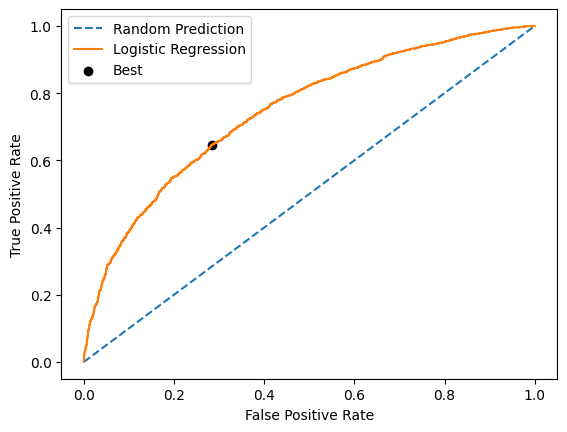

In [71]:
lr_prob2=LogReg_sdz1.predict_proba(X_train_sdz)
lr_prob2=lr_prob2[:,1]
ns_prob2=[0 for _ in range(len(y_train_sdz))]
ns_auc2=roc_auc_score(y_train_sdz, ns_prob2)
lr_auc2=roc_auc_score(y_train_sdz,lr_prob2)
print('Logistic regression with standardization')
print("AUC =", lr_auc2)

# calculate the gini index
gini_index2=2*lr_auc2-1
print("Gini index", gini_index2)

ns_fpr,ns_tpr,_=roc_curve(y_train_sdz,ns_prob2)
lr_fpr,lr_tpr,threshold_train=roc_curve(y_train_sdz,lr_prob2)

# calculate the YOUDEN statistics
fpr, tpr, thresholds = roc_curve(y_train_sdz, lr_prob2)
j_stat2 = tpr - fpr
ix = np.argmax(j_stat2)
print('Youden’s J statistic =', j_stat2[ix])

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### LogReg_l2 Logistic regression with ridge regularization.

Ridge regularization
AUC = 0.7460193423472428
Gini = 0.502620314968788
Youden’s J statistic = 0.3609476584557204


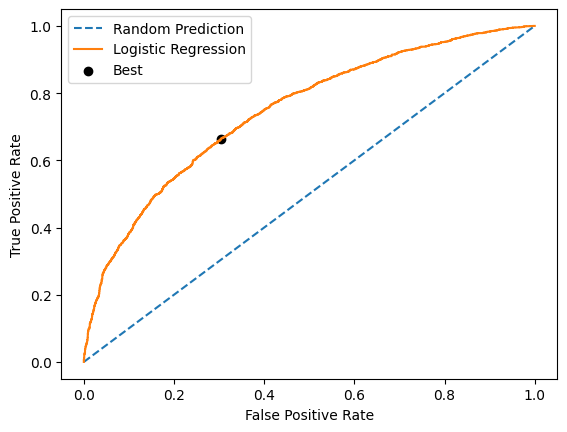

In [72]:
lr_prob3=LogReg_l2.predict_proba(X_train_sdz)
lr_prob3=lr_prob3[:,1]
ns_prob3=[0 for _ in range(len(y_train_sdz))]
ns_auc3=roc_auc_score(y_train_sdz, ns_prob3)
lr_auc3=roc_auc_score(y_train_sdz,lr_prob3)
print('Ridge regularization')
print("AUC =", lr_auc3)
# calculate the Gini coefficient
gini_coefficient3 = 2 * lr_auc - 1
print("Gini =", gini_coefficient3)


ns_fpr,ns_tpr,_=roc_curve(y_train_sdz,ns_prob3)
lr_fpr,lr_tpr,threshold_train=roc_curve(y_train_sdz,lr_prob3)

# calculate the Youden’s J statistic
j_stat3 = lr_tpr - lr_fpr
ix = np.argmax(j_stat3)
print('Youden’s J statistic =', j_stat3[ix])

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### LogReg_l1 Logistic regression with lasso regularization.


Lasso regularization
AUC =  0.7426792744839019
Gini = 0.502620314968788
Youden’s J statistic = 0.36032180045069545


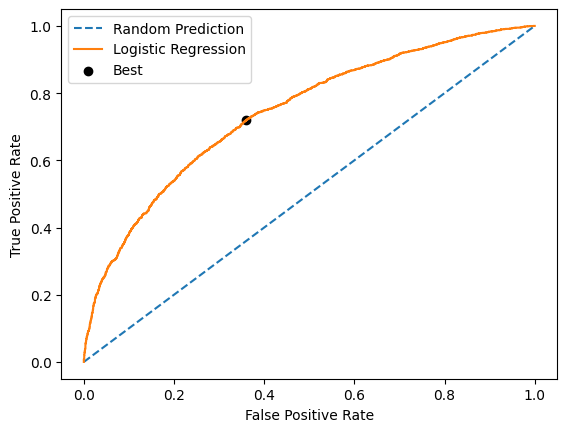

In [73]:
lr_prob4=LogReg_l1.predict_proba(X_train_sdz)
lr_prob4=lr_prob4[:,1]
ns_prob4=[0 for _ in range(len(y_train_sdz))]
ns_auc4=roc_auc_score(y_train_sdz, ns_prob4)
lr_auc4=roc_auc_score(y_train_sdz,lr_prob4)
print('Lasso regularization')
print("AUC = ", lr_auc4)

# calculate the Gini coefficient
gini_coefficient4 = 2 * lr_auc - 1
print("Gini =", gini_coefficient4)

ns_fpr,ns_tpr,_=roc_curve(y_train_sdz,ns_prob4)
lr_fpr,lr_tpr,threshold_train=roc_curve(y_train_sdz,lr_prob4)

# calculate the Youden’s J statistic
j_stat4 = lr_tpr - lr_fpr
ix = np.argmax(j_stat4)
print('Youden’s J statistic =', j_stat4[ix])

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### el_net Logistic regression with elastic net regularization

Elastic-Net regularization
AUC =  0.7460347216825964
Gini = 0.502620314968788
Youden’s J statistic = 0.3631198681586241


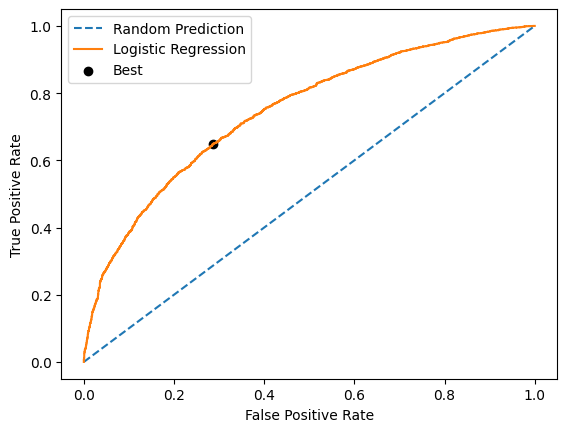

In [74]:
lr_prob5=el_net.predict_proba(X_train_sdz)
lr_prob5=lr_prob5[:,1]
ns_prob5=[0 for _ in range(len(y_train_sdz))]
ns_auc5=roc_auc_score(y_train_sdz, ns_prob5)
lr_auc5=roc_auc_score(y_train_sdz,lr_prob5)
print('Elastic-Net regularization')
print("AUC = ", lr_auc5)

# calculate the Gini coefficient
gini_coefficient5 = 2 * lr_auc - 1
print("Gini =", gini_coefficient5)

ns_fpr,ns_tpr,_=roc_curve(y_train_sdz,ns_prob5)
lr_fpr,lr_tpr,threshold_train=roc_curve(y_train_sdz,lr_prob5)

# calculate the Youden’s J statistic
j_stat5 = lr_tpr - lr_fpr
ix = np.argmax(j_stat5)
print('Youden’s J statistic =', j_stat5[ix])

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [75]:
# Threshold values
threshold = [.1, .2, .5, .8, .9]

# Create a dataframe to store results
results = pd.DataFrame(columns=["Threshold", "Accuracy", "TP rate", "TN rate", "FP rate", "Precision", "f-score"])

# Fill in the Threshold column
results['Threshold'] = threshold

# Initialize index variable
j = 0

# Iterate over the thresholds
for i in threshold:

    # If probability for the test set > threshold, predict 1
    preds = np.where(el_net.predict_proba(X_train_sdz)[:, 1] > i, 1, 0)

    # Create confusion matrix in percentage
    cm = (confusion_matrix(y_train_sdz, preds, labels=[1, 0], sample_weight=None) / len(y_train_sdz)) * 100

    # Display the confusion matrix for the current threshold
    print('Confusion matrix for threshold =', i)
    print(' ')

    TP = cm[0][0]  # True Positives
    FN = cm[0][1]  # False Positives
    FP = cm[1][0]  # True Negatives
    TN = cm[1][1]  # False Negatives

    ConMat = pd.DataFrame(
        [
            [cm[0][0], cm[0][1]],
            [cm[1][0], cm[1][1]]
        ], columns=['y_hat_1', 'y_hat_0']
    )
    ConMat.rename(index={0: 'y_1'}, inplace=True)
    ConMat.rename(index={1: 'y_0'}, inplace=True)

    print(ConMat)

    # Fill in the results dataframe
    results.iloc[j, 1] = accuracy_score(y_train_sdz, preds)
    results.iloc[j, 2] = recall_score(y_train_sdz, preds)
    results.iloc[j, 3] = TN / (FP + TN)  # True negative rate
    results.iloc[j, 4] = FP / (FP + TN)  # False positive rate
    results.iloc[j, 5] = precision_score(y_train_sdz, preds)
    results.iloc[j, 6] = f1_score(y_train_sdz, preds)

    j += 1

# Display all evaluation metrics
print('ALL METRICS')
print(results.T)

Confusion matrix for threshold = 0.1
 
       y_hat_1   y_hat_0
y_1  53.937087  0.561010
y_0  42.276097  3.225806
Confusion matrix for threshold = 0.2
 
       y_hat_1   y_hat_0
y_1  53.235824  1.262272
y_0  39.651372  5.850531
Confusion matrix for threshold = 0.5
 
       y_hat_1    y_hat_0
y_1  44.720497   9.777600
y_0  23.221799  22.280104
Confusion matrix for threshold = 0.8
 
      y_hat_1    y_hat_0
y_1  4.167502  50.330595
y_0  0.400721  45.101182
Confusion matrix for threshold = 0.9
 
      y_hat_1    y_hat_0
y_1  0.020036  54.478061
y_0  0.000000  45.501903
ALL METRICS
                  0         1         2         3         4
Threshold       0.1       0.2       0.5       0.8       0.9
Accuracy   0.571629  0.590864  0.670006  0.492687  0.455219
TP rate    0.989706  0.976838  0.820588  0.076471  0.000368
TN rate    0.070894  0.128578  0.489652  0.991193       1.0
FP rate    0.929106  0.871422  0.510348  0.008807       0.0
Precision    0.5606  0.573123  0.658213  0.912281      

## Validation set

#### LogReg Logistic Regression

Logistic regression
AUC predictions from logistic regression model = 0.7432756739909616
Gini index 0.48655134798192323
Youden’s J statistic = 0.3635966962755182


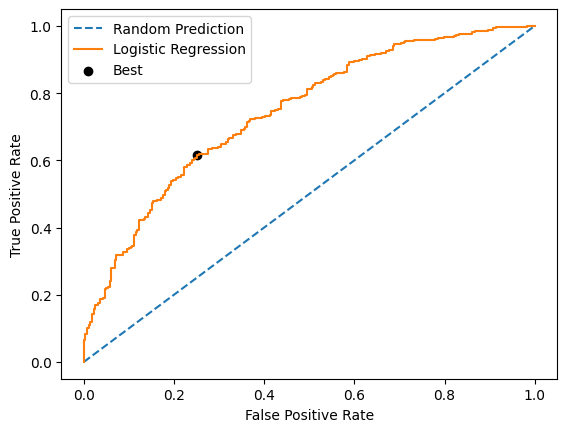

In [76]:
lr_prob=LogReg.predict_proba(X_val)
lr_prob=lr_prob[:,1]
ns_prob=[0 for _ in range(len(y_val))]
ns_auc=roc_auc_score(y_val, ns_prob)
lr_auc=roc_auc_score(y_val,lr_prob)
print('Logistic regression')
print("AUC predictions from logistic regression model =", lr_auc)
#calculate the gini index
gini_index1v=2*lr_auc-1
print("Gini index", gini_index1v)
ns_fpr,ns_tpr,_=roc_curve(y_val,ns_prob)
lr_fpr,lr_tpr,threshold_train=roc_curve(y_val,lr_prob)

# calculate the Youden’s J statistic
j_stat1v = lr_tpr - lr_fpr
ix = np.argmax(j_stat1v)
print('Youden’s J statistic =', j_stat1v[ix])

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### LogReg Logistic Regression with standardization

Logistic regression with standardization
AUC =  0.7475559711183835
Gini index 0.4951119422367669
Youden’s J statistic = 0.3720741779647811


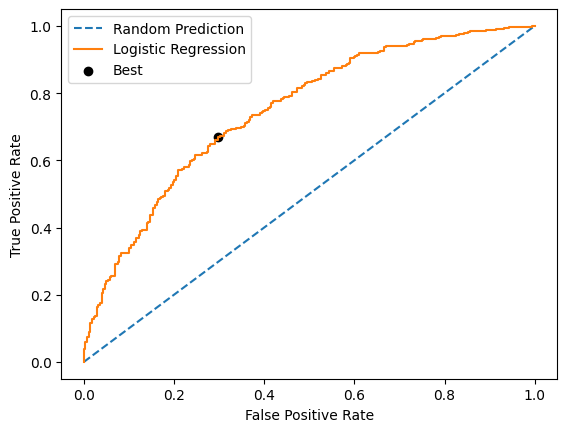

In [77]:
lr_prob2=LogReg_sdz1.predict_proba(X_val_sdz)
lr_prob2=lr_prob2[:,1]
ns_prob2=[0 for _ in range(len(y_val_sdz))]
ns_auc2=roc_auc_score(y_val_sdz, ns_prob2)
lr_auc2=roc_auc_score(y_val_sdz,lr_prob2)
print('Logistic regression with standardization')
print("AUC = ", lr_auc2)
# calculate the Gini coefficient
gini_index2v=2*lr_auc2-1
print("Gini index", gini_index2v)

ns_fpr,ns_tpr,_=roc_curve(y_val_sdz,ns_prob2)
lr_fpr,lr_tpr,threshold_train=roc_curve(y_val_sdz,lr_prob2)
# calculate the Youden’s J statistic
j_stat2v = lr_tpr - lr_fpr
ix = np.argmax(j_stat2v)
print('Youden’s J statistic =', j_stat2v[ix])

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### LogReg_l2 Logistic regression with ridge regularization.

Elastic-Net regularization
AUC predictions from logistic regression model = 0.7496130071165134
Gini index 0.4951119422367669
Youden’s J statistic = 0.39046283309957924


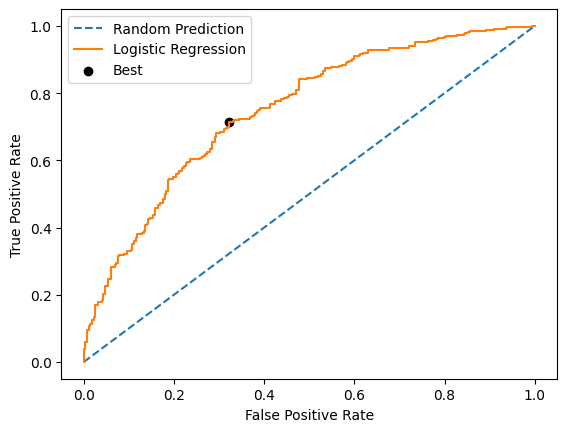

In [78]:
lr_prob2=el_net.predict_proba(X_val_sdz)
lr_prob2=lr_prob2[:,1]
ns_prob2=[0 for _ in range(len(y_val_sdz))]
ns_auc2=roc_auc_score(y_val_sdz, ns_prob2)
lr_auc2=roc_auc_score(y_val_sdz,lr_prob2)
print('Elastic-Net regularization')
print("AUC predictions from logistic regression model =", lr_auc2)
#calculate the gini index
gini_index3v=2*lr_auc2-1
print("Gini index", gini_index2v)

ns_fpr,ns_tpr,_=roc_curve(y_val_sdz,ns_prob2)
lr_fpr,lr_tpr,threshold_train=roc_curve(y_val_sdz,lr_prob2)
#calculate the Youden’s J statistic
j_stat3v = lr_tpr - lr_fpr
ix= np.argmax(j_stat3v)
print('Youden’s J statistic =', j_stat3v[ix])

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Youden statistic

The optimal threshold z is  0.5604268772641806
The TP rate according the optimal threshold z is  0.7130434782608696
The FP rate according the optimal threshold z is  0.3225806451612903


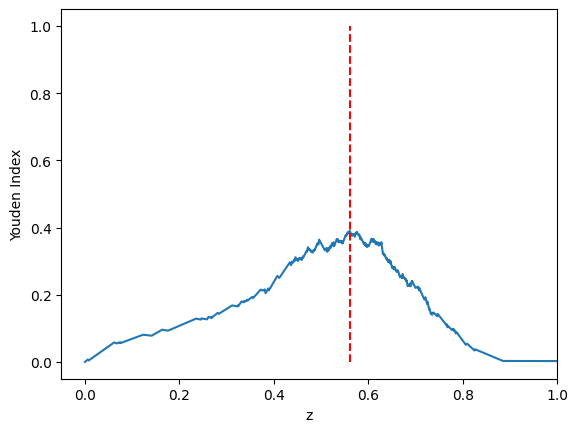

In [79]:
J = lr_tpr-lr_fpr
J_z_opt = np.argmax(J, axis=0)
print("The optimal threshold z is ",threshold_train[J_z_opt])
print("The TP rate according the optimal threshold z is ",lr_tpr[J_z_opt])
print("The FP rate according the optimal threshold z is ",lr_fpr[J_z_opt])

plt.plot(threshold_train,J)
plt.vlines(threshold_train[J_z_opt],0,1,'red','dashed')
plt.xlabel("z")
plt.ylabel("Youden Index")
plt.xlim((-0.05,1))
plt.ylim((-0.05,1.05))
pd.DataFrame({"z":threshold_train,"j":J}).to_csv("Youden_stat.csv",index=False)

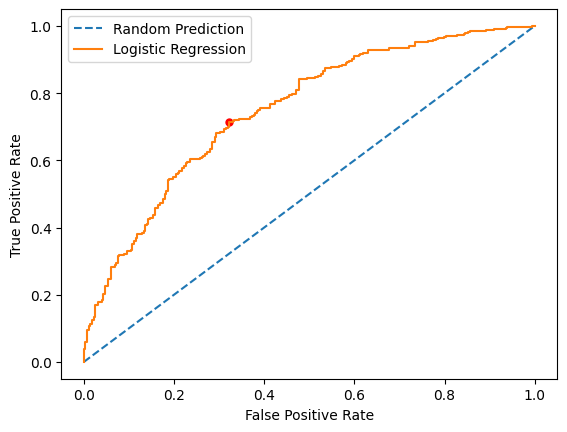

In [80]:
plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Prediction')
plt.plot(lr_fpr,lr_tpr,label='Logistic Regression')
plt.scatter(lr_fpr[J_z_opt],lr_tpr[J_z_opt],color="red",marker=None,s=25)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### LogReg_l1 Logistic regression with lasso regularization.

Lasso regularization
AUC =  0.7478053088151265
Gini index 0.49561061763025305
Youden’s J statistic = 0.377964781050335


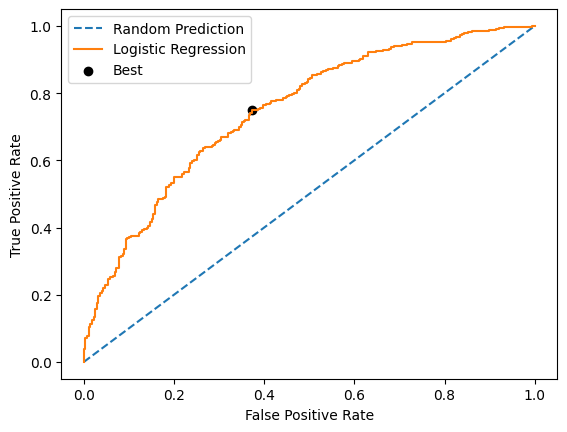

In [81]:
lr_prob4 = LogReg_l1.predict_proba(X_val_sdz)
lr_prob4 = lr_prob4[:, 1]
ns_prob4 = [0 for _ in range(len(y_val_sdz))]
ns_auc4 = roc_auc_score(y_val_sdz, ns_prob4)
lr_auc4 = roc_auc_score(y_val_sdz, lr_prob4)
print('Lasso regularization')
print("AUC = ", lr_auc4)

# calculate the Gini coefficient
gini_index4v = 2 * lr_auc4 - 1
print("Gini index", gini_index4v)

ns_fpr, ns_tpr, _ = roc_curve(y_val_sdz, ns_prob4)
lr_fpr, lr_tpr, threshold_train = roc_curve(y_val_sdz, lr_prob4)

# calculate the Youden’s J statistic
j_stat4v = lr_tpr - lr_fpr
ix = np.argmax(j_stat4v)
print('Youden’s J statistic =', j_stat4v[ix])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


#### el_net Logistic regression with elastic net regularization

Elastic-Net regularization
AUC =  0.7496130071165134
Gini index 0.4992260142330267
Youden’s J statistic = 0.39046283309957924


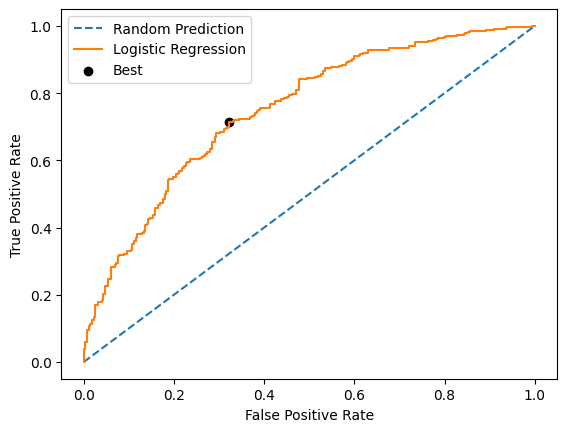

In [82]:
lr_prob5 = el_net.predict_proba(X_val_sdz)
lr_prob5 = lr_prob5[:, 1]
ns_prob5 = [0 for _ in range(len(y_val_sdz))]
ns_auc5 = roc_auc_score(y_val_sdz, ns_prob5)
lr_auc5 = roc_auc_score(y_val_sdz, lr_prob5)
print('Elastic-Net regularization')
print("AUC = ", lr_auc5)

# calculate the Gini coefficient
gini_index5v = 2 * lr_auc5 - 1
print("Gini index", gini_index5v)

ns_fpr, ns_tpr, _ = roc_curve(y_val_sdz, ns_prob5)
lr_fpr, lr_tpr, threshold_train = roc_curve(y_val_sdz, lr_prob5)

# calculate the Youden’s J statistic
j_stat5v = lr_tpr - lr_fpr
ix = np.argmax(j_stat5v)
print('Youden’s J statistic =', j_stat5v[ix])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### Random forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

rf_classifier = RandomForestClassifier(n_estimators=22, random_state=42)
rf_classifier.fit(X_train, y_train)

#y train pred
y_train_pred= rf_classifier.predict(X_train)
#y test pred
y_test_pred= rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred) / len(y_test)
#mse
msetest = mse(y_test, y_test_pred)
msetrain = mse(y_train, y_train_pred)


print("Accuracy:", accuracy)
print("MSE test:", msetest, "MSE train:", msetrain)
print("Precision:", precision)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

<ipython-input-83-1d31e58b9848>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Accuracy: 0.6955128205128205
MSE test: 0.30448717948717946 MSE train: 0.003205770386696053
Precision: 0.697986577181208
F1 Score: 0.6864686468646864
Confusion Matrix:
 [[0.36217949 0.14423077]
 [0.16025641 0.33333333]]


##### Train set

Random Forest
AUC =  0.9999459294946512
Gini index 0.9998918589893024
Youden’s J statistic = 0.993681521485741


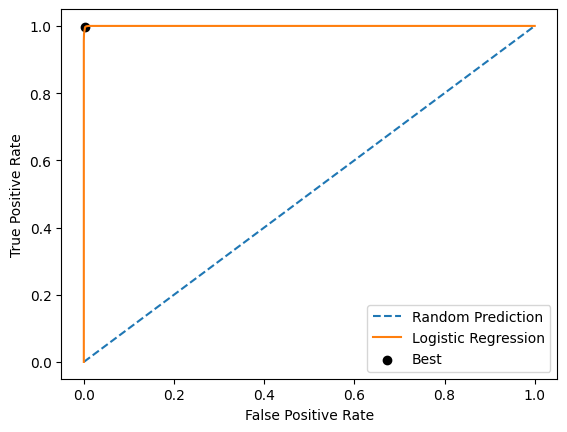

In [84]:
lr_probrf = rf_classifier.predict_proba(X_train)
lr_probrf = lr_probrf[:, 1]
ns_probrf = [0 for _ in range(len(y_train))]
ns_aucrf = roc_auc_score(y_train, ns_probrf)
lr_aucrf = roc_auc_score(y_train, lr_probrf)
print('Random Forest')
print("AUC = ", lr_aucrf)

# calculate the Gini coefficient
gini_indexrf = 2 * lr_aucrf - 1
print("Gini index", gini_indexrf)

ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probrf)
lr_fpr, lr_tpr, threshold_train = roc_curve(y_train, lr_probrf)

# calculate the Youden’s J statistic
j_statrf = lr_tpr - lr_fpr
ix = np.argmax(j_statrf)
print('Youden’s J statistic =', j_statrf[ix])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#####Validation set

Random Forest
AUC =  0.7556854189392759
Gini index 0.5113708378785518
Youden’s J statistic = 0.3656537322736481


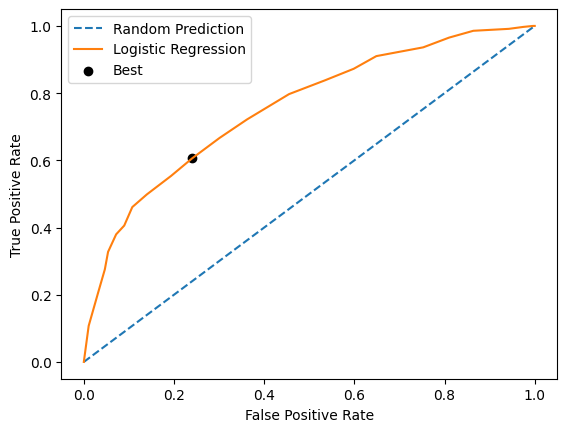

In [85]:
lr_probrf = rf_classifier.predict_proba(X_val)
lr_probrf = lr_probrf[:, 1]
ns_probrf = [0 for _ in range(len(y_val))]
ns_aucrf = roc_auc_score(y_val, ns_probrf)
lr_aucrf = roc_auc_score(y_val, lr_probrf)
print('Random Forest')
print("AUC = ", lr_aucrf)

# calculate the Gini coefficient
gini_indexrf = 2 * lr_aucrf - 1
print("Gini index", gini_indexrf)

ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probrf)
lr_fpr, lr_tpr, threshold_train = roc_curve(y_val, lr_probrf)

# calculate the Youden’s J statistic
j_statrf = lr_tpr - lr_fpr
ix = np.argmax(j_statrf)
print('Youden’s J statistic =', j_statrf[ix])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### XGBOOST

##### Train set

Accuracy: 72.76%
Log Loss:  9.819585057932558
AUC:  0.7176250584385226
              precision    recall  f1-score   support

         0.0       0.46      0.35      0.40       316
         1.0       0.47      0.58      0.52       308

    accuracy                           0.47       624
   macro avg       0.47      0.47      0.46       624
weighted avg       0.47      0.47      0.46       624



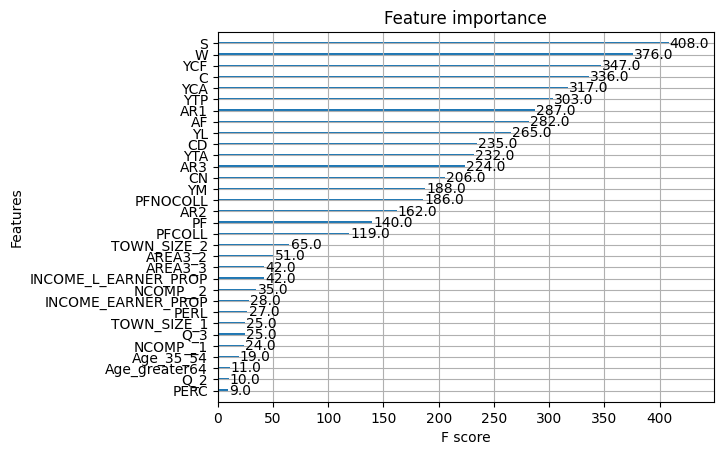

In [86]:
from xgboost import XGBClassifier  # Import the XGBClassifier class
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import classification_report
from xgboost import plot_importance
import matplotlib.pyplot as plt


# different objective function: binary:hinge that is used for binary classification with a hinge loss
model_xgb = XGBClassifier(objective= 'binary:hinge', colsample_bytree= 0.5, learning_rate= 0.05)
model_xgb.fit(X_train_sdz, y_train_sdz)

# make prediction
y_pred = model_xgb.predict(X_val_sdz)

# calculate the accuracy
accuracy = model_xgb.score(X_val_sdz, y_val_sdz)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Log Loss: ", log_loss(y_val_sdz, y_pred))
print("AUC: ", roc_auc_score(y_val_sdz, y_pred))

print(classification_report(y_test_sdz, y_pred))



plot_importance(model_xgb)
plt.show()


Accuracy: 70.19%
Log Loss:  10.743781298679151
AUC:  0.7009505999688328
              precision    recall  f1-score   support

         0.0       0.50      0.46      0.48       316
         1.0       0.49      0.52      0.50       308

    accuracy                           0.49       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.49      0.49      0.49       624



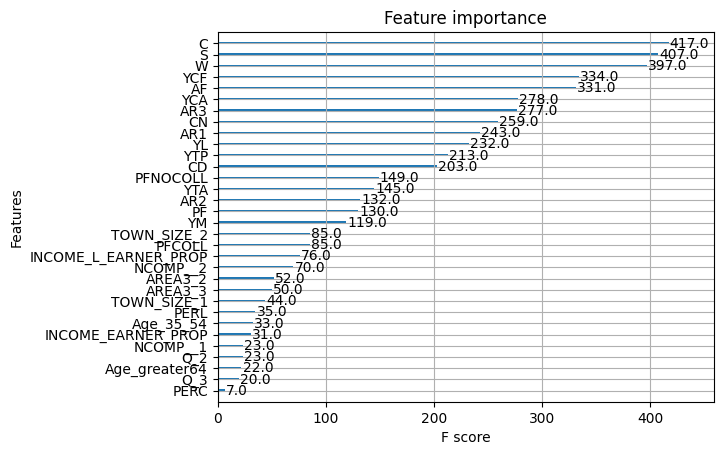

In [87]:
# different objective function: binary:logistic that is used for binary classification with a logistic loss
model_xgb = XGBClassifier(objective= 'binary:logistic', colsample_bytree= 0.5, learning_rate= 0.05)
model_xgb.fit(X_train_sdz, y_train_sdz)

# make prediction
y_pred = model_xgb.predict(X_val_sdz)

# calculate the accuracy
accuracy = model_xgb.score(X_val_sdz, y_val_sdz)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Log Loss: ", log_loss(y_val_sdz, y_pred))
print("AUC: ", roc_auc_score(y_val_sdz, y_pred))

print(classification_report(y_test_sdz, y_pred))

plot_importance(model_xgb)
plt.show()



XGBoost on train
AUC =  0.9292095669179166
Gini index 0.8584191338358331
Youden’s J statistic = 0.6995994897298418


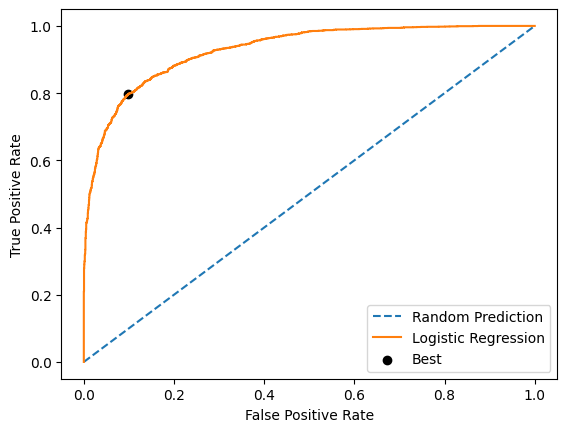

In [88]:
lr_probxgb = model_xgb.predict_proba(X_train_sdz)
lr_probxgb = lr_probxgb[:, 1]
ns_probxgb = [0 for _ in range(len(y_train_sdz))]
ns_aucxgb = roc_auc_score(y_train_sdz, ns_probxgb)
lr_aucxgb = roc_auc_score(y_train_sdz, lr_probxgb)
print('XGBoost on train')
print("AUC = ", lr_aucxgb)

# calculate the Gini coefficient
gini_indexxgb = 2 * lr_aucxgb - 1
print("Gini index", gini_indexxgb)

ns_fpr, ns_tpr, _ = roc_curve(y_train_sdz, ns_probxgb)
lr_fpr, lr_tpr, threshold_train = roc_curve(y_train_sdz, lr_probxgb)

# calculate the Youden’s J statistic
j_statxgb = lr_tpr - lr_fpr
ix = np.argmax(j_statxgb)
print('Youden’s J statistic =', j_statxgb[ix])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### Validation set

XGBoost on validation
AUC =  0.7879902342735443
Gini index 0.5759804685470886
Youden’s J statistic = 0.43590462833099575


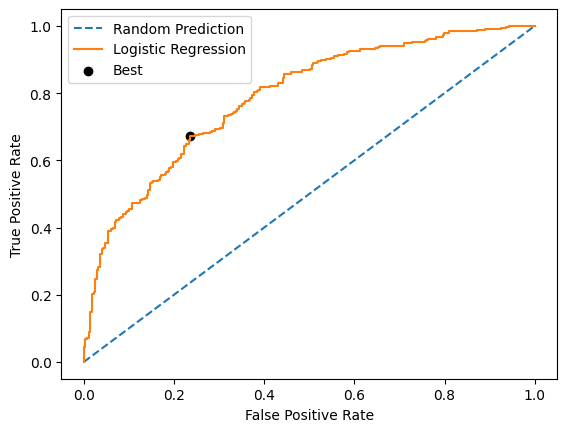

In [89]:
lr_probxgb = model_xgb.predict_proba(X_val_sdz)
lr_probxgb = lr_probxgb[:, 1]
ns_probxgb = [0 for _ in range(len(y_val_sdz))]
ns_aucxgb = roc_auc_score(y_val_sdz, ns_probxgb)
lr_aucxgb = roc_auc_score(y_val_sdz, lr_probxgb)
print('XGBoost on validation')
print("AUC = ", lr_aucxgb)

# calculate the Gini coefficient
gini_indexxgb = 2 * lr_aucxgb - 1
print("Gini index", gini_indexxgb)

ns_fpr, ns_tpr, _ = roc_curve(y_val_sdz, ns_probxgb)
lr_fpr, lr_tpr, threshold_train = roc_curve(y_val_sdz, lr_probxgb)

# calculate the Youden’s J statistic
j_statxgb = lr_tpr - lr_fpr
ix = np.argmax(j_statxgb)
print('Youden’s J statistic =', j_statxgb[ix])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [90]:
# Threshold values
threshold = [.1, .2, .5, .8, .9]

# Create a dataframe to store results
results = pd.DataFrame(columns=["Threshold", "Accuracy", "TP rate", "TN rate", "FP rate", "Precision", "f-score"])

# Fill in the Threshold column
results['Threshold'] = threshold

# Initialize index variable
j = 0

# Iterate over the thresholds
for i in threshold:

    # If probability for the val set > threshold, predict 1
    preds = np.where(model_xgb.predict_proba(X_val_sdz)[:, 1] > i, 1, 0)

    # Create confusion matrix in percentage
    cm = (confusion_matrix(y_val_sdz, preds, labels=[1, 0], sample_weight=None) / len(y_val_sdz)) * 100

    # Display the confusion matrix for the current threshold
    print('Confusion matrix for threshold =', i)
    print(' ')

    TP = cm[0][0]  # True Positives
    FN = cm[0][1]  # False Positives
    FP = cm[1][0]  # True Negatives
    TN = cm[1][1]  # False Negatives

    ConMat = pd.DataFrame(
        [
            [cm[0][0], cm[0][1]],
            [cm[1][0], cm[1][1]]
        ], columns=['y_hat_1', 'y_hat_0']
    )
    ConMat.rename(index={0: 'y_1'}, inplace=True)
    ConMat.rename(index={1: 'y_0'}, inplace=True)

    print(ConMat)

    # Fill in the results dataframe
    results.iloc[j, 1] = accuracy_score(y_val_sdz, preds)
    results.iloc[j, 2] = recall_score(y_val_sdz, preds)
    results.iloc[j, 3] = TN / (FP + TN)  # True negative rate
    results.iloc[j, 4] = FP / (FP + TN)  # False positive rate
    results.iloc[j, 5] = precision_score(y_val_sdz, preds)
    results.iloc[j, 6] = f1_score(y_val_sdz, preds)

    j += 1

# Display all evaluation metrics
print('ALL METRICS')
print(results.T)

Confusion matrix for threshold = 0.1
 
       y_hat_1   y_hat_0
y_1  55.288462  0.000000
y_0  43.750000  0.961538
Confusion matrix for threshold = 0.2
 
       y_hat_1   y_hat_0
y_1  54.487179  0.801282
y_0  36.698718  8.012821
Confusion matrix for threshold = 0.5
 
       y_hat_1    y_hat_0
y_1  39.262821  16.025641
y_0  13.782051  30.929487
Confusion matrix for threshold = 0.8
 
       y_hat_1    y_hat_0
y_1  20.833333  34.455128
y_0   2.403846  42.307692
Confusion matrix for threshold = 0.9
 
       y_hat_1    y_hat_0
y_1  14.743590  40.544872
y_0   1.282051  43.429487
ALL METRICS
                  0         1         2         3         4
Threshold       0.1       0.2       0.5       0.8       0.9
Accuracy     0.5625     0.625  0.701923   0.63141  0.581731
TP rate         1.0  0.985507  0.710145  0.376812  0.266667
TN rate    0.021505  0.179211  0.691756  0.946237  0.971326
FP rate    0.978495  0.820789  0.308244  0.053763  0.028674
Precision  0.558252   0.59754  0.740181  0.896552

In [91]:
# Threshold values
threshold = [.1, .2, .5, .8, .9]

# Create a dataframe to store results
results = pd.DataFrame(columns=["Threshold", "Accuracy", "TP rate", "TN rate", "FP rate", "Precision", "f-score"])

# Fill in the Threshold column
results['Threshold'] = threshold

# Initialize index variable
j = 0

# Iterate over the thresholds
for i in threshold:

    # If probability for the test set > threshold, predict 1
    preds = np.where(el_net.predict_proba(X_test_sdz)[:, 1] > i, 1, 0)

    # Create confusion matrix in percentage
    cm = (confusion_matrix(y_test_sdz, preds, labels=[1, 0], sample_weight=None) / len(y_test_sdz)) * 100

    # Display the confusion matrix for the current threshold
    print('Confusion matrix for threshold =', i)
    print(' ')

    TP = cm[0][0]  # True Positives
    FN = cm[0][1]  # False Positives
    FP = cm[1][0]  # True Negatives
    TN = cm[1][1]  # False Negatives

    ConMat = pd.DataFrame(
        [
            [cm[0][0], cm[0][1]],
            [cm[1][0], cm[1][1]]
        ], columns=['y_hat_1', 'y_hat_0']
    )
    ConMat.rename(index={0: 'y_1'}, inplace=True)
    ConMat.rename(index={1: 'y_0'}, inplace=True)

    print(ConMat)

    # Fill in the results dataframe
    results.iloc[j, 1] = accuracy_score(y_test_sdz, preds)
    results.iloc[j, 2] = recall_score(y_test_sdz, preds)
    results.iloc[j, 3] = TN / (FP + TN)  # True negative rate
    results.iloc[j, 4] = FP / (FP + TN)  # False positive rate
    results.iloc[j, 5] = precision_score(y_test_sdz, preds)
    results.iloc[j, 6] = f1_score(y_test_sdz, preds)

    j += 1

# Display all evaluation metrics
print('ALL METRICS')
print(results.T)

Confusion matrix for threshold = 0.1
 
       y_hat_1   y_hat_0
y_1  48.397436  0.961538
y_0  46.634615  4.006410
Confusion matrix for threshold = 0.2
 
       y_hat_1   y_hat_0
y_1  47.756410  1.602564
y_0  44.391026  6.250000
Confusion matrix for threshold = 0.5
 
       y_hat_1    y_hat_0
y_1  40.224359   9.134615
y_0  27.243590  23.397436
Confusion matrix for threshold = 0.8
 
      y_hat_1    y_hat_0
y_1  4.487179  44.871795
y_0  0.160256  50.480769
Confusion matrix for threshold = 0.9
 
     y_hat_1    y_hat_0
y_1      0.0  49.358974
y_0      0.0  50.641026
ALL METRICS
                  0         1         2         3        4
Threshold       0.1       0.2       0.5       0.8      0.9
Accuracy   0.524038  0.540064  0.636218  0.549679  0.50641
TP rate    0.980519  0.967532  0.814935  0.090909      0.0
TN rate    0.079114  0.123418  0.462025  0.996835      1.0
FP rate    0.920886  0.876582  0.537975  0.003165      0.0
Precision  0.509275  0.518261    0.5962  0.965517      0.0
f-sco

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
results = {
    'Model': ['Logistic Regression', 'Logistic Regression with standardization', 'Ridge regularization', 'Lasso regularization', 'Elastic-Net regularization','Random Forest','XGBoost'],
    'AUC': [lr_auc, lr_auc2, lr_auc3, lr_auc4, lr_auc5,lr_aucrf,lr_aucxgb],
    'Gini': [gini_index, gini_index2, gini_index3v, gini_index4v, gini_index5v,gini_indexrf,gini_indexxgb],
    #'Youden': [j_stat1v[ix], j_stat2v[ix], j_stat3v[ix], j_stat4v[ix], j_stat5v[ix], j_statrf[ix], j_statxgb[ix]]
}

# create a dataframe
results_df = pd.DataFrame(results)
print(results_df)

                                      Model       AUC      Gini
0                       Logistic Regression  0.743276  0.502620
1  Logistic Regression with standardization  0.749613  0.492963
2                      Ridge regularization  0.746019  0.499226
3                      Lasso regularization  0.747805  0.495611
4                Elastic-Net regularization  0.749613  0.499226
5                             Random Forest  0.755685  0.511371
6                                   XGBoost  0.787990  0.575980


##Test set

XGBoost on validation
AUC =  0.7710216998191681
Gini index 0.5420433996383363
Youden’s J statistic = 0.43325661680092065


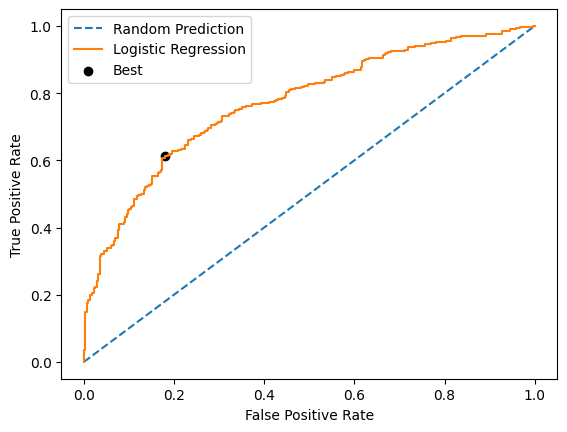

In [93]:
lr_probxgb = model_xgb.predict_proba(X_test_sdz)
lr_probxgb = lr_probxgb[:, 1]
ns_probxgb = [0 for _ in range(len(y_test_sdz))]
ns_aucxgb = roc_auc_score(y_test_sdz, ns_probxgb)
lr_aucxgb = roc_auc_score(y_test_sdz, lr_probxgb)
print('XGBoost on validation')
print("AUC = ", lr_aucxgb)

# calculate the Gini coefficient
gini_indexxgb = 2 * lr_aucxgb - 1
print("Gini index", gini_indexxgb)

ns_fpr, ns_tpr, _ = roc_curve(y_test_sdz, ns_probxgb)
lr_fpr, lr_tpr, threshold_train = roc_curve(y_test_sdz, lr_probxgb)

# calculate the Youden’s J statistic
j_statxgb = lr_tpr - lr_fpr
ix = np.argmax(j_statxgb)
print('Youden’s J statistic =', j_statxgb[ix])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [94]:
# Threshold values
threshold = [.1, .2, .5, .8, .9]

# Create a dataframe to store results
results = pd.DataFrame(columns=["Threshold", "Accuracy", "TP rate", "TN rate", "FP rate", "Precision", "f-score"])

# Fill in the Threshold column
results['Threshold'] = threshold

# Initialize index variable
j = 0

# Iterate over the thresholds
for i in threshold:

    # If probability for the test set > threshold, predict 1
    preds = np.where(model_xgb.predict_proba(X_test_sdz)[:, 1] > i, 1, 0)

    # Create confusion matrix in percentage
    cm = (confusion_matrix(y_test_sdz, preds, labels=[1, 0], sample_weight=None) / len(y_test_sdz)) * 100

    # Display the confusion matrix for the current threshold
    print('Confusion matrix for threshold =', i)
    print(' ')

    TP = cm[0][0]  # True Positives
    FN = cm[0][1]  # False Positives
    FP = cm[1][0]  # True Negatives
    TN = cm[1][1]  # False Negatives

    ConMat = pd.DataFrame(
        [
            [cm[0][0], cm[0][1]],
            [cm[1][0], cm[1][1]]
        ], columns=['y_hat_1', 'y_hat_0']
    )
    ConMat.rename(index={0: 'y_1'}, inplace=True)
    ConMat.rename(index={1: 'y_0'}, inplace=True)

    print(ConMat)

    # Fill in the results dataframe
    results.iloc[j, 1] = accuracy_score(y_test_sdz, preds)
    results.iloc[j, 2] = recall_score(y_test_sdz, preds)
    results.iloc[j, 3] = TN / (FP + TN)  # True negative rate
    results.iloc[j, 4] = FP / (FP + TN)  # False positive rate
    results.iloc[j, 5] = precision_score(y_test_sdz, preds)
    results.iloc[j, 6] = f1_score(y_test_sdz, preds)

    j += 1

# Display all evaluation metrics
print('ALL METRICS')
print(results.T)

Confusion matrix for threshold = 0.1
 
       y_hat_1   y_hat_0
y_1  49.198718  0.160256
y_0  49.839744  0.801282
Confusion matrix for threshold = 0.2
 
       y_hat_1   y_hat_0
y_1  47.916667  1.442308
y_0  43.589744  7.051282
Confusion matrix for threshold = 0.5
 
       y_hat_1    y_hat_0
y_1  34.935897  14.423077
y_0  14.903846  35.737179
Confusion matrix for threshold = 0.8
 
       y_hat_1    y_hat_0
y_1  17.307692  32.051282
y_0   3.365385  47.275641
Confusion matrix for threshold = 0.9
 
      y_hat_1    y_hat_0
y_1  9.775641  39.583333
y_0  0.801282  49.839744
ALL METRICS
                  0         1         2         3         4
Threshold       0.1       0.2       0.5       0.8       0.9
Accuracy        0.5  0.549679  0.706731  0.645833  0.596154
TP rate    0.996753  0.970779  0.707792  0.350649  0.198052
TN rate    0.015823  0.139241  0.705696  0.933544  0.984177
FP rate    0.984177  0.860759  0.294304  0.066456  0.015823
Precision  0.496764  0.523643  0.700965  0.837209  0